# Russian Layout Optimization with Bigrams

In [1]:
from lib import Corpus, Keyboard, Layout, Result, STANDARD_KBD, std_key_shape, STD_EXTRA_KEYS, ERGODOX, compare, BASE_KEYS_RU
import pandas as pd
from collections import defaultdict

# Contents

- [How this all works](#hiw)
- [How to test your layout](#how-to-test-your-layout)
- [Initialization and code](#init)
    - [Loading sample texts](#loading-texts)
        - [Some stats on bigrams](#some-stats)
    - [The code with the scoring rules](#scoring-code)
- [Comparing existing and my new layouts](#layouts)
- [Side-to-side comparisons of the best](#side-to-side)
- [Final standings](#standings)
    - [Finger Load Comparison](#finger-load)
    - [Which Rows do Keys Gravitate to](#rows-gravitation)
    - [Bigrams vs Position Penalties](#bigram-position-chart)
- [Test your layout here](#your-layout)
    - [Export any layout to Linux XKB](#export-to-xkb)
    - [Compare with others](#compare)
    - [Output statistics in CSV](#output-statistics)
    - [Simple statistics of costs](#simple-stats)
    - [Where do letters want to move?](#letters-move)
- [Heatmaps](#heatmaps)


## How This All Works <a name="hiw">

The code is organized in simple to use classes.
    
```
Corpus ------------------------------------------------> | Result
  .bigrams                                        /----> |   .score
                                                 /           .bigrams (w/ scores)
Keyboard ------------------>  Layout -----------/            .layout
  .keymap                       .keyboard                    .corpus
  (fingers & penalties)         .keymap
                                (keys w/ positions)
```

* `Corpus` stores bigrams dataframe, with frequencies and basic info about the letters for categorial analysis.
* `Keyboard` stores a dict: {(row, column): (finger, monogram penalty, ...)}
* To make a new Keyboard, provide it with fingers and penalties strings (see `STANDARD_KBD` and `ERGODOX` below).
* `Layout` takes keyboard, makes the dict a dataframe and adds keys to it.
* `Result` stores score and bigrams costs dataframes.
* `Result` can compare itself with another one, or better call `compare(results_dict, key1, key2)` to do things automatically.

## Testing Your Layout <a name="how-to-test-your-layout">

1. Run the cell with the code to make `CORP` and `STANDARD_KBD` (or another one).
1. Go to [Insert Your Layout](#your-layout) section.
2. Modify the layout, maintaining columns' positions, so that they match `STANDARD_KBD.fingers`.
3. Run the code & see the score.
4. Compare your layout to another one in the cells below that.

## Loading Sample Texts <a name="loading-texts">

This is a sample from Strugatski brothers' "Inhabited Island" and Michail Bulgakov's "White Guard", roughly 500K of characters. Compared to my own texts assembled in 300K chars, some letters differ slightly: letter И (i) is much less popular. I don't know what to do with this.

In [2]:
CORP = Corpus.from_path('../sampletexts.txt', 'sample1.txt', 'sample2.txt', types={'v': 'аеёиоуъыьэюя', 'c': 'бвгджзйклмнпрстфхцчшщ'})

In [3]:
CORP.bigrams

bigram   num l1 l2 t1 t2      freq
0        ¶м   159  ¶  м  -  c  0.000175
1        мо  3241  м  о  c  v  0.003562
2        ож  1890  о  ж  v  c  0.002077
3        же  2825  ж  е  c  v  0.003104
4        ет  5188  е  т  v  c  0.005701
...     ...   ... .. .. .. ..       ...
2584     г!     1  г  !  c  -  0.000001
2585     v¶     3  v  ¶  -  -  0.000003
2586     ⌴?     2  ⌴  ?  -  -  0.000002
2587     -ю     1  -  ю  -  v  0.000001
2588     кы     2  к  ы  c  v  0.000002

[2589 rows x 7 columns]

In [4]:
CORP.bigrams[(CORP.bigrams.t1 != '-') & (CORP.bigrams.t2 != '-')].groupby('l2').agg({'num': 'sum'}).sort_values('num', ascending=False)


num
l2       
о   71953
е   58485
а   54530
и   44490
т   42844
н   34442
р   30362
л   28374
с   26001
в   19409
к   17751
м   17190
д   16076
у   15816
ы   13770
ь   13741
я   12830
з    8539
й    8515
г    8426
б    7297
ч    7212
ж    5906
х    5796
п    5655
ю    4653
ш    4591
ц    2550
щ    2470
ё    1222
ф     938
ъ     273
э     268

# Some stats on bigrams <a name="some-stats">

## Vowels outer or inner?

Negative = wants more to be on outer keys, positive = more to inner.

freq_out     freq_in      outer   frequency     outerness
ъ   2.956041    0.000000  -2.956041    2.956041 -10000.000000
ы  19.010968    0.032967 -18.978001   19.043935  -9965.377957
ь   9.901088    0.021978  -9.879110    9.923066  -9955.703212
а  53.988952    7.065926 -46.923025   61.054878  -7685.385169
о  45.065885    9.736253 -35.329632   54.802138  -6446.761580
у  16.076905    4.769226 -11.307680   20.846131  -5424.354244
и  71.483438   26.285685 -45.197753   97.769123  -4622.906598
е  21.428548  103.318568  81.890020  124.747116   6564.482030
я   5.659334   54.461479  48.802144   60.120813   8117.346006
э   0.032967    1.450548   1.417581    1.483515   9555.555556
ю   0.395604   35.988971  35.593367   36.384575   9782.543038
ё   0.000000    2.868129   2.868129    2.868129  10000.000000

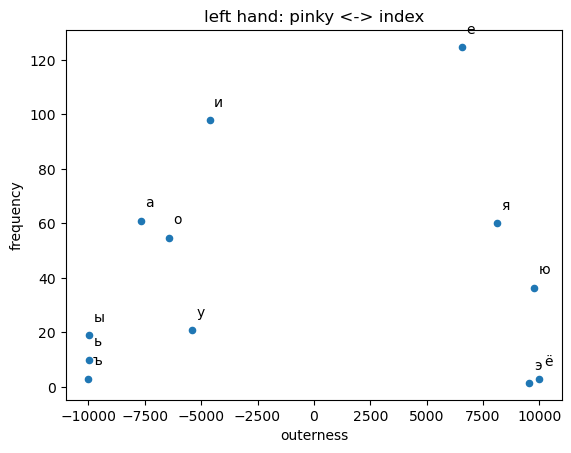

In [5]:
CORP.display_outerness("(t1 == 'v') & (t2 == 'v')", True)

## Consonants

In my layout, С (s) is the outermost (but in home column), Р (r) and Н (n) are innermost (in home column). Т comes too often before Р (-tr- is frequent like in English), so it isn't on the index finger.

freq_out     freq_in       outer   frequency    outerness
l1                                                             
щ     0.703296    5.054940   -4.351644    5.758235 -7557.251908
ц     1.175823    8.428562   -7.252739    9.604385 -7551.487414
л    21.549427   82.582327  -61.032900  104.131754 -5861.122837
р    52.010932  166.120697 -114.109765  218.131628 -5231.234257
н    62.692239  157.252574  -94.560336  219.944813 -4299.275543
т   103.681205  184.153644  -80.472439  287.834849 -2795.785133
к    43.505447   74.439479  -30.934032  117.944925 -2622.752259
м    21.670306   23.692282   -2.021976   45.362588  -445.736434
ф     2.626371    2.692305   -0.065934    5.318675  -123.966942
в    67.582343   61.791141    5.791202  129.373484   447.634418
ш    13.164821   10.197791    2.967030   23.362612  1269.990593
д    53.824117   40.285670   13.538447   94.109787  1438.580103
х     8.241749    5.692301    2.549448   13.934051  1829.652997
г    27.648321   11.988998   15.659323   39.637319  3950.651511
ж    21.988987    7.945046   14.043941   29.934033  4691.629956
с   242.065668   86.516388  155.549280  328.582057  4733.955386
ч    40.054901   11.065922   28.988979   51.120823  5670.679278
п    81.395515   21.582394   59.813121  102.977909  5808.344894
б    30.340626    5.692301   24.648325   36.032927  6840.500152
з    55.626312    4.219776   51.406537   59.846088  8589.790672
й    19.857121    0.010989   19.846132   19.868110  9988.938053

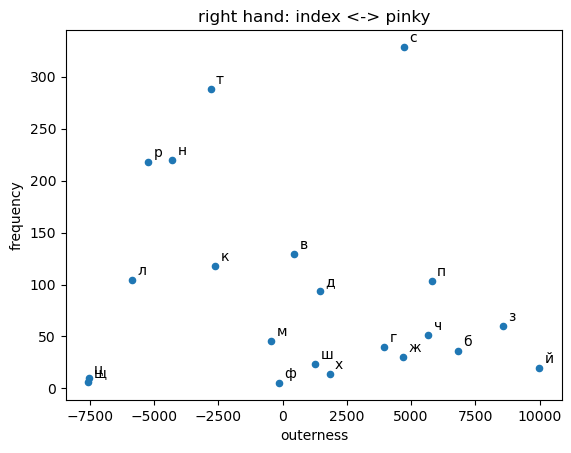

In [6]:
CORP.display_outerness("t1 == 'c' & t2 == 'c'")

Outputting the bigrams to Excel file, to see stats for each letter -- what letters come before it, and what ones come after.

In [7]:
BG = CORP.bigrams
dg2 = BG[BG.l1.isin(BASE_KEYS_RU) & BG.l2.isin(BASE_KEYS_RU)].copy()
dg2['kind_after'] = dg2.t2
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_before', 'prev'], fill_value=0)
dg2['dir'] = 'after'
pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_after', 'next'], fill_value=0)
dg3 = pd1.join(pd2)
dg3

dg3.melt(ignore_index=False).rename(
    columns={'variable_0': 'dir', 'variable_1': 'kind', 'variable_2': 'other', 'value': 'num'}
).reset_index().to_csv('all-letters-melt.csv')

# How Standard Keyboard is Really Used

In [8]:
real_kbd = Keyboard('real fingers', ''' 
000012 3678999
000123 66789999
 abcd3 6ghij99
 01233 667899
e
''', '''
753222 4222357
621112 43112346
 10002 2000124
 21114 411123
0
''',
std_key_shape, STD_EXTRA_KEYS)

# Layouts <a name="layouts">

## Rules:

1. Spaces/linebreaks ARE SIGNIFICANT! (Except at the beginning and end of the whole string -- those are stripped.)
2. Two linebreaks = new level (Shift, AltGr), except for start and end of the whole string.
3. Rows must be in the same order.
4. Letters positions must match those in `FINGERS` and `POS_PENALTY` strings of th keyboard (`STANDARD_KBD` by default).
5. Backslash (`\`) requires Python's raw string syntax: `r''`. Otherwise, duplicate it -- but it creates a lot of confusion with positions.
6. `∅` means no letter at all (or same letter as in lower level). Currently, we don't compute penalties for Shift/AltGr.
7. `¶` means Enter key, and every linebreak in text is treated as hitting this key.
8. `⌴` means space. This is irrelevant for skewed keyboards (they get 0 for any digrams with space), but will be needed for Ergodox.
9. `→` means Tab. Tabs in the text are also scored as keypresses (although in literature corpus they're absent, but if we inserted any text with tables, we'd be able to account for the tab key).
    
## How to test Ergodox and other non-standard models
    
By default, these layouts are used with standard staggered keyboard. If you want Ergodox, then instead of 1 string provide a 2-tuple:
    
```python
    'my_layout': (r'''<the layout>''', ERGODOX),
```
    
If you want different key positions, make a different `Keyboard` instance:
    
```python
    'my_layout': (r'''<the layout>''', Keyboard(<fingers>, <penalties>)),
```
    
search for `леонов` (new finger positions in standard kbd) and `optozorax` (Ergodox) in the dictionary below for examples.

In [9]:
LEONOV_KBD = Keyboard("leonov's remapping", '''
0001233 667899
0001233 667899
 0abcd3 6ghij9
 001233 6678
e
''',

'''
7532226 622235
6321134 431123
 210002 200012
 311114 4111
0
''',
# '''
# 3211113 311123
# 2111112 211112
#  200001 100001
#  111112 2111
# 0
# ''',
#  '''
# 4322224 422234
# 3211123 321123
#  200002 200002
#  211113 3111
# 0
# ''',
         std_key_shape, STD_EXTRA_KEYS
)

In [10]:
layouts = {
    # standard Russian layout ~1890
    'йцукен': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фывап ролджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
 ∅∅∅∅∅ ∅∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
''',

    # QWERTY transliterated ~1970
    'usphonetic': r'''
    
ю12345 67890-ь
→яверт ыуиопшщэ
 асдфг чйкл;'¶
 зхцжб нм,.%
⌴

∅!"ёЁъ Ъ?*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅:"∅
 ∅∅∅∅∅ ∅∅<>?
''',

    # Dvorak transliterated ~2000
    'rusdvorak': r'''
    
ю12345 67890шщ
→',.пы фгцрл/чэ
 аоеуи дхтнс-¶
 ;яйкь бмвжз
⌴

∅!@ё∅ъ %&*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅?∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # "Dictor" layout 200?
    'диктор': r'''
    
ё12345 67890-=
→цья,. звкдчшщ
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

∅ъ"№;% :∅*()∅_+
∅∅∅∅?! ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # Zubachov's layout 2007
    'зубачёв': r'''
    
ё12345 67890-=
→фыаяъ ймрпхцщ
 гиеоу лтснзж¶
 шью.э бдвкч
⌴

∅!"№;% :\?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅,∅ ∅∅∅∅∅
''',

    # Skoropis 2014 (literally "Fastwrite") from https://cont.ws/@russkivek/93620
    # in fact, it's just a slightly Diktor with improved punctuation
    'скоропис': r'''
    
*.ёъ?! ∅-\'()∅
→цья,. звкдчшщ"
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

%12345 67890∅∅
∅∅∅∅;: ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',

    # ANT layout 200?
    # this layout put Ъ's upper and lower case in different places,
    # which my code doesn't understand.
    # had to put the letter on one key to process
    'ант': r'''
    
\!?'"= +-*/%()
→гпрдм ыияухцжч
 внстл ьоеакз¶
 щйшб, .юэёф
⌴

_97531 02468""
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ъ∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅
''',
    
    # UNGVS 2019 https://ubuntu-mate.community/t/make-your-own-custom-keyboard-layout-for-linux/19733/
    'ugnvs': r'''
    
`12345 67890-=
→пдмкз буяьыг:'
 аиеол внтср,¶
 щцэюф хчжйш
⌴

~!?/$% <>*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅;"
 ∅∅∅∅∅ ∅∅∅∅∅.∅
 ∅∅∅∅∅ ∅∅∅∅


∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅ъ∅∅∅∅
 ∅∅ё∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',
    
    # Leonov 2023 https://habr.com/ru/articles/717912/
    # author uses chords for comma and period, here instead they're put in 3rd layer on index fingers.
'леонов': # 
('''
∅123456 7890-=
→щцклбй ъыяэфш
 чзвнтд иаоес¶
 жхпрмг ёьую
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅.∅ ∅,∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''',
LEONOV_KBD),
'леонов2': # 
('''
∅123456 7890-=
→чгкблщ ёэыяфш
 цснтрд йиаое¶
 жзпмвх ъюуь
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅,∅ ∅.∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
'леонов3': # 
('''
ъ123456 7890-=
→щчклбй ёыяэфш
 цсвнтд иаоеп¶
 жзхрмг ьую,
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅.
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
    
    # my layouts 2021
    'тест1': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фыоап рвлджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест2': r'''
    
ё12345 67890-=
→йцуюк енгбзхъ\
 ыоаия втсрпч¶
 элмдь жшщф.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест3': r'''

ё12345 67890-=
→ъцуюя ьнгбчхй\
 ыоаие втсрпз¶
 эфкмд жшщл.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест4': r'''
    
ё12345 67890-=
→ъэуюя цлнгчхй\
 оаыеи втсрпз¶
 фдьмк жшщб.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест5': r'''
    
ё12345 67890-=
→ъуьюя йлнгчцх\
 оаыеи втсрпз¶
 .фжэд мкшщб
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест6': r'''
    
/12345 67890-=
→ёъьую янвгчйцх
 оиаые лрптсз¶
 ,эфшщ кбмдж
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
   
    'тест7': r'''
    
/12345 67890-=
→ёъьую янджчйцх
 оиаые лрптсз¶
 ,эфшщ вбмкг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест8': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфшщ вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # 2021, the first tested on a real keyboard
  'тест9': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфщш вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # my layouts below: 2024. #10 is the first after manual test
  'тест10': r'''
    
/12345 67890-=
→ёоюэф йнзкдчжц
 ауиея лртпбс¶
 ъыьшщ вмхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
  'тест11': r'''
    
/12345 67890-=
→ёоюяф лндкзчжц
 ауиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
''',
  'тест12': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест13': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест14': r'''
    
/12345 67890-=
→ёуюяф лндпзчжц
 аоиеэ вртксб¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест15': r'''
    
/12345 67890-=
→ёуюяф шндпзчжц
 аоиеэ вртксб¶
 щыъьй млхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест16': r'''    
/12345 67890-=
→ёуюяф шндгзчжц
 аоиеэ вртксб¶
 щыъьй млхп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    
'тест17': r'''    
/12345 67890-=
→ёуюяф шндмзчжц
 аоиеэ вртксб¶
 щыъьй хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест18': r'''    
/12345 67890-=
→ьуюяй шндмзчжц
 аоиеэ вртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест19': r'''    
/12345 67890-=
→ьуюяэ шндмвчжц
 аоией зртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест20': r'''    
/12345 67890-=
→ьуюяэ шнмдвчжц
 аоией гртксз¶
 щыъёф хлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест21': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест22': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест23': r'''    
/12345 67890-=
→ъыфхэ шнмвдчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест24': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксб¶
 ьуюяё щ.лпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅,∅∅∅
∅
''', 
'тест25': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксч¶
 ьуюяё щлпб.
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',
    # alien layout experiment #1, with rare letters Ё Щ Ъ on AltGr
    'ино1': r'''    
/12345 67890+
→:ыфхэ цнмвчзж
 аоией ,ртксд¶
 ьуюя- шлбпг
⌴

\!"№∅% ∅?*_()
∅;∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅= ∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅ё∅ ∅∅∅∅∅∅∅
 ъ∅∅∅∅ щ∅∅∅∅
∅
''',

    'тест26': r'''

ъ12345 67890-=
→щфыхё цнмвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    'тест27': r'''

ъ12345 67890-=
→эыфх: цнмвчзжш
 аоией ,ртксд¶
 ьуюяё щлбпг
⌴

\!"№∅% ∅?*()_+
∅∅∅∅∅; ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
    # Alien layout #2, with voiced consonants on AltGr over their voiceless counterparts.
    # e.g. in English B<->P, T (mat) <-> D (mad), K (keel) <-> G (good), V <-> F,
    # Russian has more pairs.
    # same for vowels: compound vowels Я Ю Ё and rare Ё Э are on AltGr,
    # Ы is separated twin of И and also is put there
    
    # This scores great, but abuses the scoring system, because Shift & AltGr aren't penalized
    # In reality, it's hard to hit and release AltGr quickly
    'ино2': r'''

 12345 67890
→-()х: цнмфш+=
 аоией ,ртксч¶
 ьу я! щл п? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅вж∅∅
 ∅ёыэ∅ ∅∅дгз∅∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
'тест28': r'''

ъ12345 67890-=
→щфыхё цмнвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

    'тест29': r'''

ъ12345 67890-=
→щфыхё цмнкчзж/
 аоией ,ртвсд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
  'ино3': r'''

 12345 67890
→-()х: +кмфшщ=
 аоией ,ртнсч¶
 ьу  !  лп ? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅г∅вж∅∅
 яёыэ∅ ∅д∅зц∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
    
'тест30': r'''

ъ12345 67890-=
→щфыхэ жвмкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест31': r'''

ъ12345 67890-=
→щфыхэ жмвкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест32': r'''

ъ12345 67890-=
→ьыхяё жшвкчзщ/
 аоией ,ртнсд¶
 пуфюэ цлмбг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест32букваП': r'''    
ъ12345 67890-=
→фуыхэ жшвкчзщ/
 поией ,ртнсд¶
 ьаёяю цлмбг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест33': r'''

ъ12345 67890-=
→щфыхэ жмвкзчш/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест34': r'''

ъ12345 67890-=
→щфыхэ шмвкчзж/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
'тест35': r'''

ъ12345 67890-=
→чкдзг эхшыцьф/
 снтрм йеиоа,¶
 впблж ёяющу
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅.
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест36': r'''

ъ12345 67890-=
→щфыхэ цзмквчш/
 аиоей ,ртнсг¶
 ьуюяё жлдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест37': r'''
ъ12345 67890-=
→фцыхё шмвкзжэ
 аиое, йртнсч¶
 щьуяю глдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест38': r'''
ъ12345 67890-=
→фэыхё жмвкчшц
 аиое, йртнсз¶
 щьуяю глдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест39': r'''
ъ12345 67890-=
→фёыхэ шмвкчйц
 аиое, зртнсг¶
 щьуяю жлдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    

'тест40': r'''
ъ12345 67890-=
→фцыёэ шмвкзчх
 аиое, йртнсг¶
 щьуяю жлдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
 
'тест41': r'''
ъ12345 67890-=
→фцыёэ швкдгжх
 аоие, лрнтсз¶
 щьуяю ймбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест42': r'''
ъ12345 67890-=
→фыцэё шбвдгжх
 аоие, лрнтсз¶
 щьуяю ймкпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
}

    

In [11]:
results = {}

for k, definition in layouts.items():
    if isinstance(definition, str):
        definition = (definition, real_kbd)
    lyt = Layout(k, definition)
    print(f'layout {k}: ', end='')
    results[k] = r = Result(CORP, lyt)
    print(round(r.score, 4))

layout йцукен: 2.9586
key "?" repeated: 2
key """ repeated: 2
layout usphonetic: 3.3914
layout rusdvorak: 1.6986
key ":" repeated: 2
layout диктор: 1.4684
layout зубачёв: 1.5102
key "." repeated: 2
layout скоропис: 1.4389
key ";" repeated: 2
key """ repeated: 3
key ":" repeated: 2
layout ант: 1.8055
layout ugnvs: 1.9728
layout леонов: 1.1786
layout леонов2: 1.0814
layout леонов3: 1.2865
layout тест1: 2.6957
layout тест2: 2.3658
layout тест3: 2.0777
layout тест4: 1.8944
layout тест5: 1.7134
layout тест6: 1.7875
layout тест7: 1.8006
layout тест8: 1.7718
layout тест9: 1.7785
layout тест10: 1.6774
layout тест11: 1.6938
layout тест12: 1.589
layout тест13: 1.5887
layout тест14: 1.5375
layout тест15: 1.481
layout тест16: 1.4739
layout тест17: 1.4444
layout тест18: 1.4471
layout тест19: 1.4803
layout тест20: 1.4799
layout тест21: 1.4464
layout тест22: 1.4464
layout тест23: 1.429
layout тест24: 1.3896
layout тест25: 1.434
layout ино1: 1.2374
layout тест26: 1.3683
layout тест27: 1.3691
layout ин

# Final Standings <a name="standings">

In [12]:
print('Standard keyboard league:\n')
chosen_kbd = [
    ('йцукен', 'Default Russian kbd'),
    ('usphonetic', 'QWERTY transit'),
    ('rusdvorak', 'Dvorak translit'),
    ('диктор', 'Dictor'),
    ('зубачёв', 'Zubachov'),
    ('скоропис', 'Skoropis'),
    ('ант', 'ANT'),
    ('ugnvs', 'UGNVS'),
    ('леонов', 'Leonov'),
    ('тест1', 'Def.Rus with couple of letters swapped'),
    ('тест2', 'My first Dvorak analog'),
    ('тест9', 'First hand-tested'),
    ('тест10', 'First optimized after hand testing'),
    ('ино1', 'Alien #1, rare letters on AltGr'),
    ('тест40', 'Best and currently in use on my laptop'),
    ('тест42', 'Proposed new variant'),
    ('ино2', 'Alien #2, many counterparts on AltGr'),
]
print(
    pd.DataFrame([(k, results[k].score.round(3), d) for k, d in chosen_kbd],
        columns=['layout', 'score', 'comment']).sort_values('score', ascending=True)
    .to_markdown(index=False)
)

# ergodox layouts moved to another notebook, see the folder

Standard keyboard league:

| layout     |   score | comment                                |
|:-----------|--------:|:---------------------------------------|
| ино2       |   0.986 | Alien #2, many counterparts on AltGr   |
| леонов     |   1.179 | Leonov                                 |
| ино1       |   1.237 | Alien #1, rare letters on AltGr        |
| тест42     |   1.268 | Proposed new variant                   |
| тест40     |   1.298 | Best and currently in use on my laptop |
| скоропис   |   1.439 | Skoropis                               |
| диктор     |   1.468 | Dictor                                 |
| зубачёв    |   1.51  | Zubachov                               |
| тест10     |   1.677 | First optimized after hand testing     |
| rusdvorak  |   1.699 | Dvorak translit                        |
| тест9      |   1.778 | First hand-tested                      |
| ант        |   1.806 | ANT                                    |
| ugnvs      |   1.973 | UGNVS                   

# Test Your Layout Here <a name="your-layout">
    
To measure this for a different keyboard, or different fingers positions, add Keyboard instance:
```python
'my_layout': (r'''
<layout definition>
''', Keyboard('my_special_kbd', ''' 
000012 3678999
000113 66789999
 abcd3 6ghij99
 01233 667899
e
''', '''
864222 4222468
622123 43112246
 00002 2000024
 11114 411112
0
'''))
```

To the results above: the Test27 layout seems very good, and I use it to type in Russian sometimes, but there's still some awkwardness to it. And it actually has much disbalance to the right hand. It's 20% more loaded and gets 80% more penalties.

IDK if I made something useful or just abuse my own scoring system.

тест43 : 1.298 


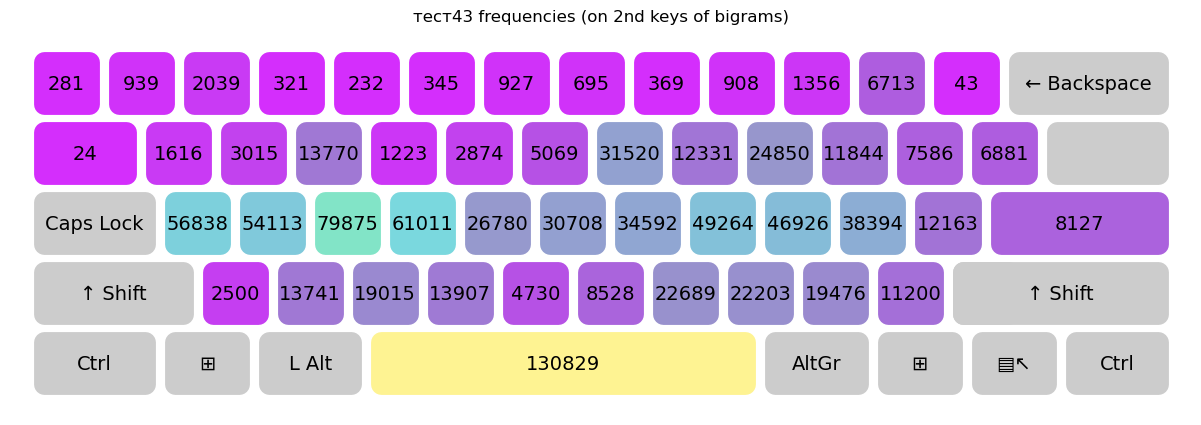

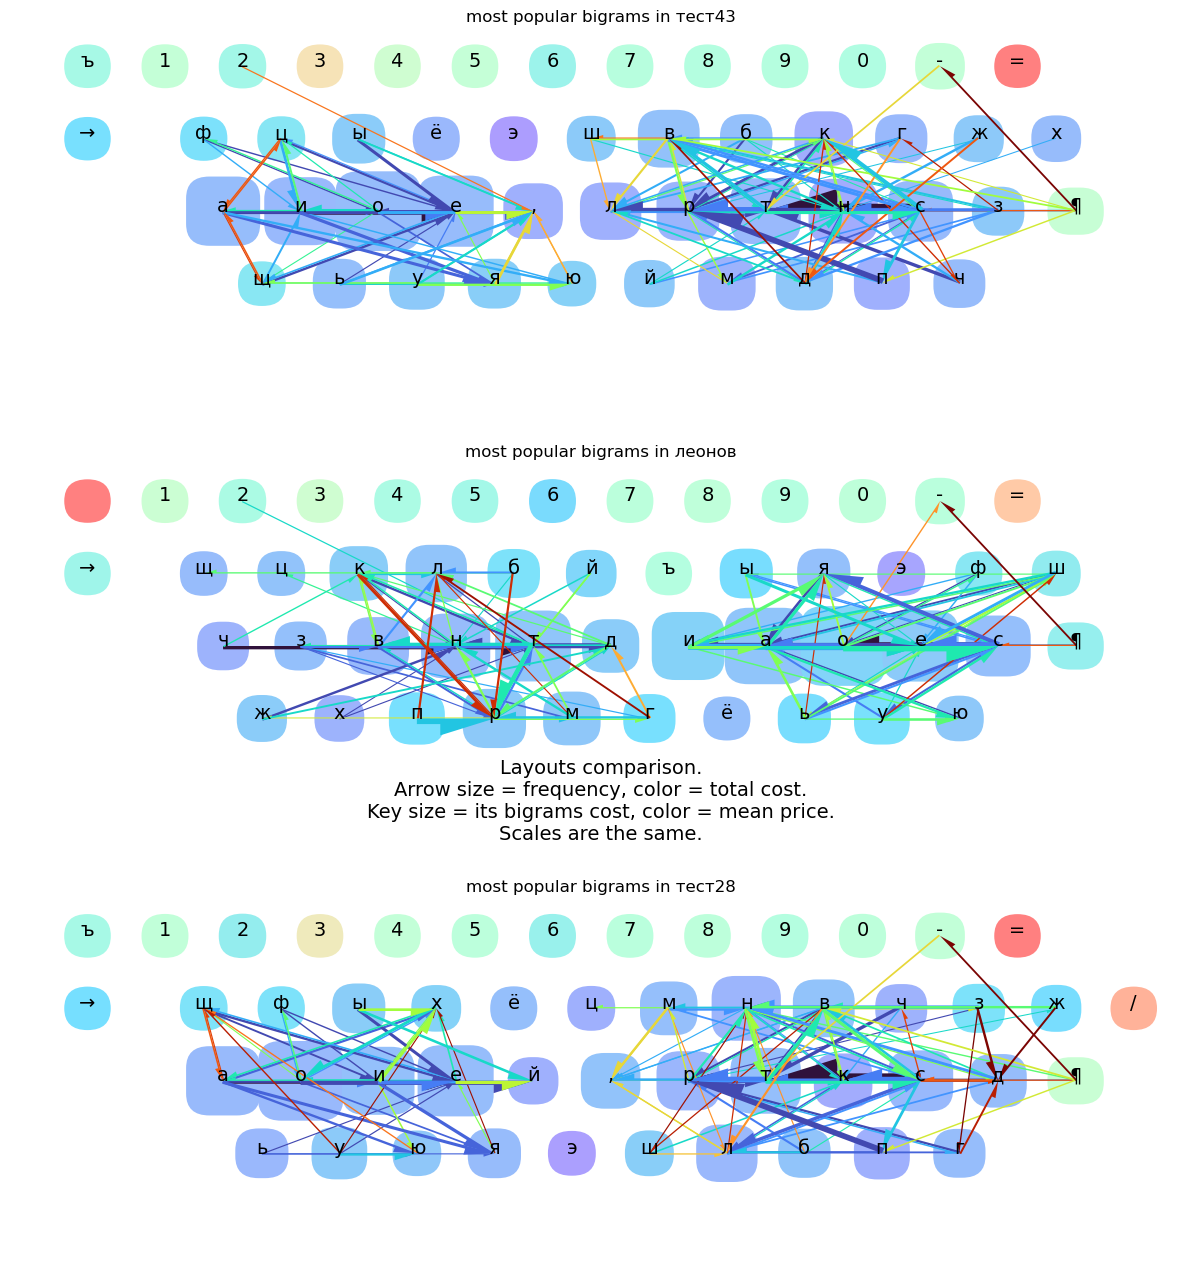

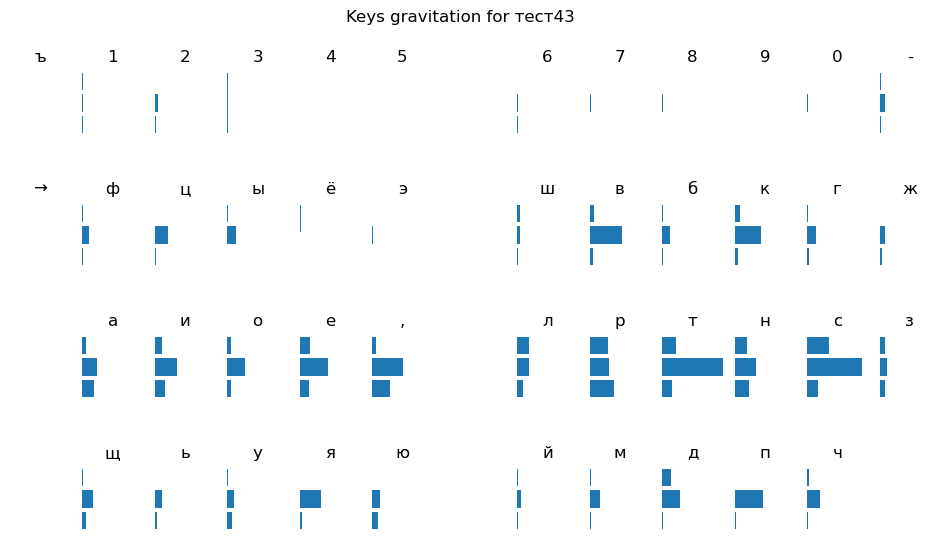

In [13]:
# →щфыхэ цзмквчш/
#  аиоей ,ртнсг¶
#  ьуюяё жлдпб

lyt = Layout('тест43', (r'''
ъ12345 67890-=
→фцыёэ швбкгжх
 аиое, лртнсз¶
 щьуяю ймдпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''', real_kbd))


results[lyt.name] = r = Result(CORP, lyt)
print(lyt.name, ':', round(r.score, 3), '')

r.display('freq')
r.combomap(results['леонов'], results['тест28'])
r.display('rows')

check which side and row letters gravitate to in a layout result (this depends on corpus stats, hence it should be done in a Result instance)


## Finger Load Comparison <a name='finger-load'/>

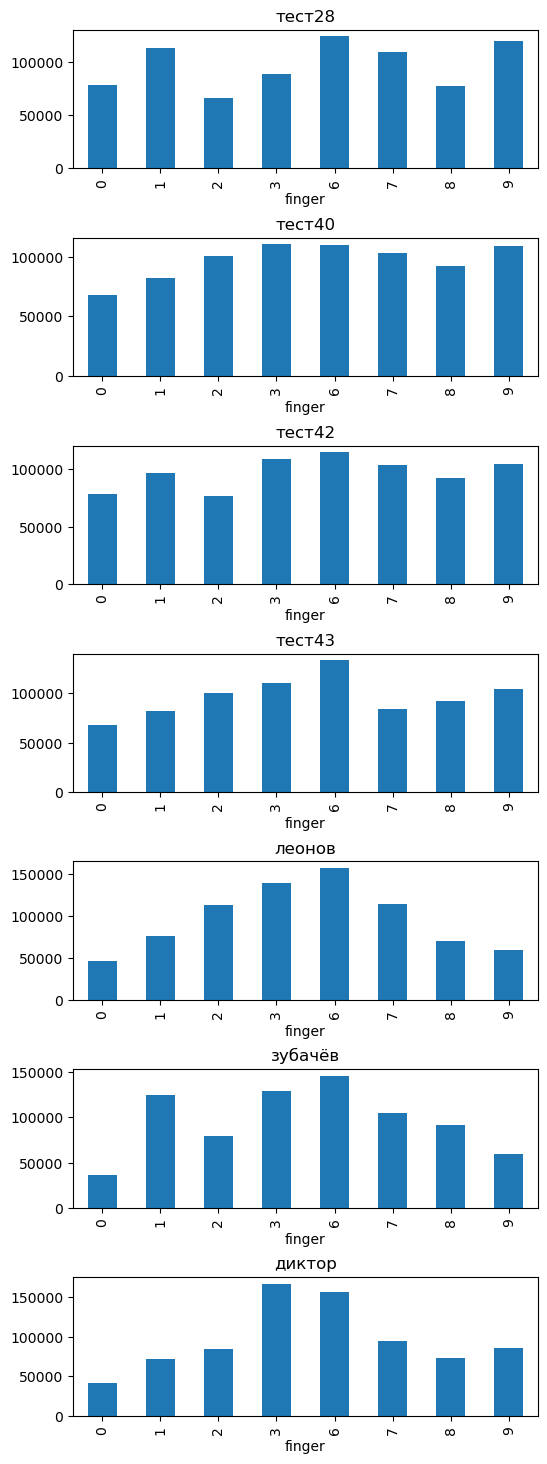

In [14]:
keys = ('тест28', 'тест40', 'тест42', 'тест43', 'леонов', 'зубачёв', 'диктор')
from matplotlib import pyplot as plt
fig, axs = plt.subplots(len(keys), 1, figsize=(6, 18))
plt.subplots_adjust(hspace=.5)
dfs = []
for k, ax in zip(keys, axs):
    d = results[k].bigrams
    d = d[d.finger != 4].groupby('finger').agg({'num': 'sum'})
    d.plot.bar(ax=ax, title=k, legend=False)

## Which Rows do Keys Gravitate to <a name='rows-gravitation'>
    
In this chart, we show how many bigrams do letters have with rows 1-3 (main key rows). If a key in bottom row has most bigrams in bottom or middle row, it's fine in that position. This chart actually shows that almost all letters are in their best places.
    
note: This calculation excludes combos with keys on another hand, and with the key itself (НН is quite popular that it distorts the stats significantly).

Letter В (v) may gain a little bit in the bottom row, but letters in that row will loose more.

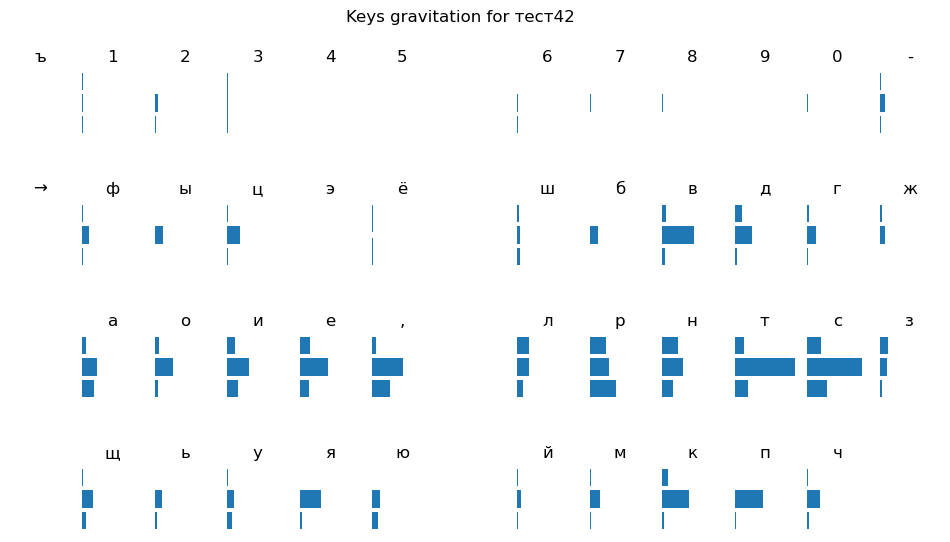

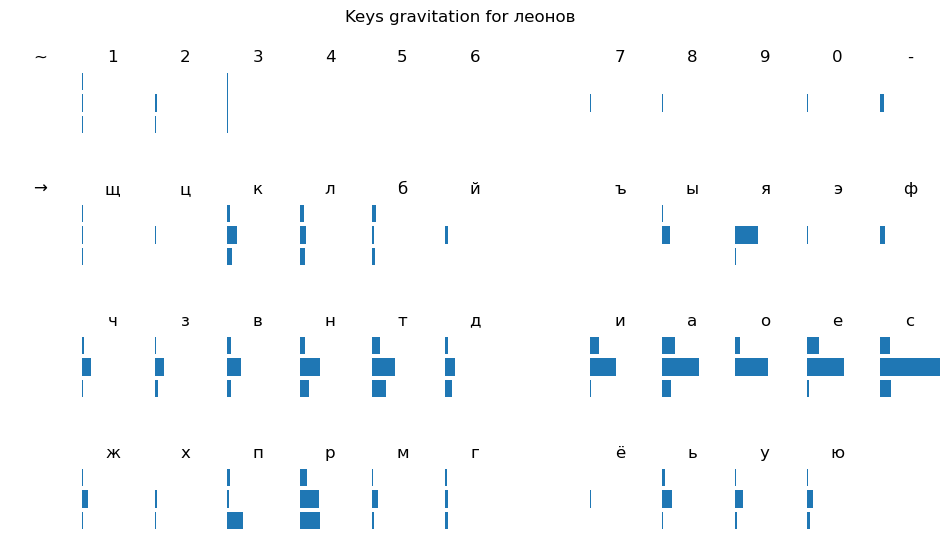

In [15]:
results['тест42'].display('rows')
results['леонов'].display('rows')

# Bigrams vs Position Penalties <a name='bigram-position-chart'/>

### Theoretical minimal score

This calculation shows how low could the score be if we put keys ordered by frequencies, and there were no bigrams penalties:

In [16]:
pos_penalties = STANDARD_KBD.keymap['penalty'].values
pos_penalties.sort()
freqs = CORP.bigrams.groupby('l2').agg({'freq': 'sum'}).sort_values('freq', ascending=False).values
min_score = sum(a * b for a, b in zip(freqs, pos_penalties))[0]
min_score

0.6756344223797554

name    pos   move  coord  bigram
0       йцукен  1.418  0.819  1.431   2.250
1   usphonetic  1.360  1.055  1.657   2.711
2    rusdvorak  1.003  0.524  0.673   1.197
3       диктор  0.902  0.515  0.502   1.017
4      зубачёв  0.811  0.552  0.553   1.105
5          ант  1.013  0.729  0.569   1.299
6        ugnvs  0.865  0.462  1.078   1.540
7       леонов  0.778  0.321  0.469   0.790
8        тест1  1.418  0.833  1.154   1.987
18      тест11  1.151  0.665  0.453   1.118
34      тест27  0.908  0.522  0.393   0.915
46      тест38  0.808  0.459  0.444   0.902
47      тест39  0.799  0.457  0.443   0.899
48      тест40  0.815  0.464  0.427   0.891
49      тест41  0.852  0.463  0.387   0.850
50      тест42  0.808  0.463  0.401   0.864

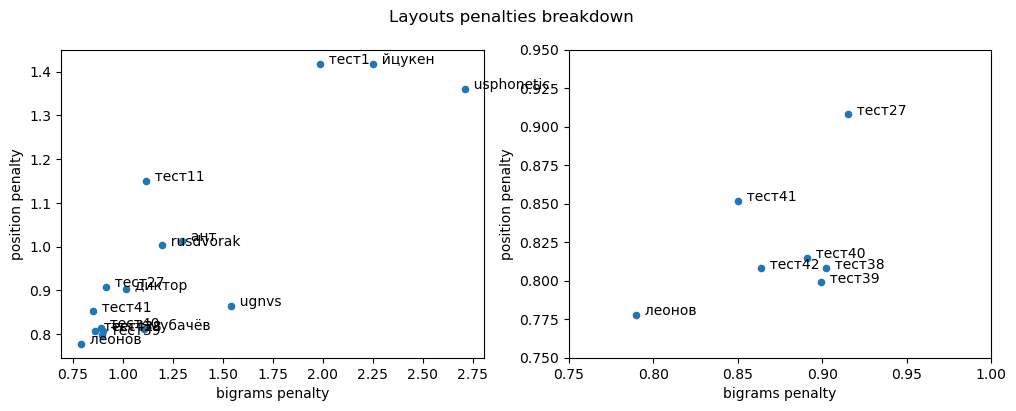

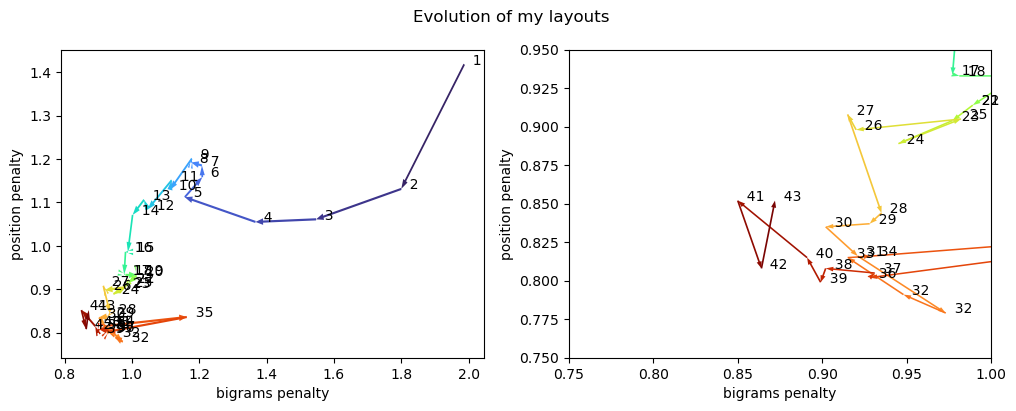

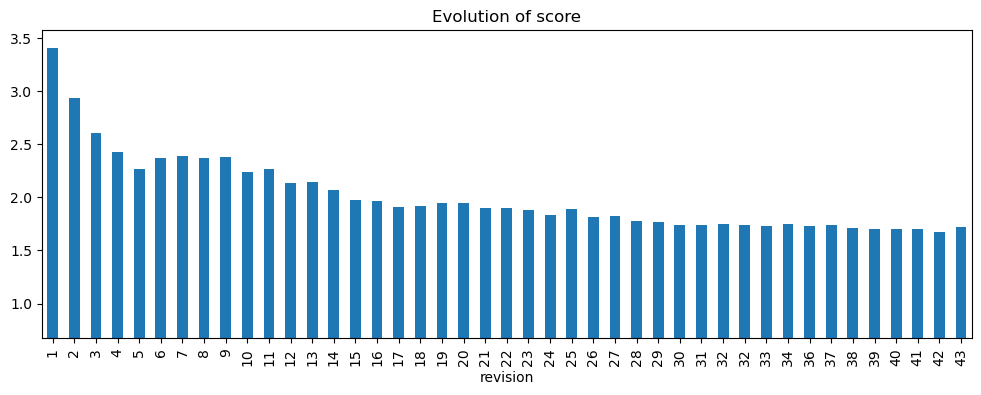

In [17]:
xlims = (0.75, 1.)
ylims = (0.75, 0.95)

dd = []
for k, v in results.items():
#    if k.startswith('тест') and not k.startswith('тест37'): continue
    if k.startswith('леонов') and not k == 'леонов': continue
    if k.startswith('ино'): continue
    if k.startswith('скоропис'): continue
    b = results[k].bigrams
    bgcost = b.coord_cost + b.move_cost
    dd.append({
        'name': k, 
        'pos': round((b.penalty * b.num).sum() / b.num.sum(), 3),
        'move': round((b.move_cost * b.num).sum() / b.num.sum(), 3),
        'coord': round((b.coord_cost * b.num).sum() / b.num.sum(), 3),
        'bigram': round((bgcost * b.num).sum() / b.num.sum(), 3)
    })
    
df2 = pd.DataFrame(dd)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
lims = (0.6, 1.0)
# selecting layouts to display their scores
df3 = df2[~df2.name.str.startswith('тест') | df2.name.isin([
    'тест42', 'тест41', 'тест40', 'тест39', 'тест38', 'тест27', 'тест1', 'тест11'])]
for ax in (ax1, ax2):
    df3.plot.scatter(x='bigram', y='pos', ax=ax)
    for i, rw in df3.iterrows():
        ax.annotate('  ' + str(rw['name']), (rw.bigram, rw.pos))

    for a in (ax1, ax2):
        a.set_xlabel('bigrams penalty')
        a.set_ylabel('position penalty')

ax2.set_xlim(*xlims)
ax2.set_ylim(*ylims)
        
fig.suptitle('Layouts penalties breakdown')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Evolution of my layouts')

import re
df4 = df2[df2.name.apply(lambda k: re.match(r'тест(\d+)', k) is not None)].copy()
df4['revision'] = df4.name.apply(lambda k: int(re.match(r'тест(\d+)', k).groups()[0]))
df4.sort_values('revision', inplace=True)
df4['pos1'] = df4.pos.diff(-1)
df4['bigram1'] = df4.bigram.diff(-1)
maxnum = df4.revision.max() - 1

for ax, w in zip((ax1, ax2), (.005, .001)):
    ax.set_xlabel('bigrams penalty')
    ax.set_ylabel('position penalty')
    for _, rw in df4.iterrows():
        ax.arrow(
            rw['bigram'], rw['pos'], -rw['bigram1'], -rw['pos1'],
            width=w,
            length_includes_head=True, ec='#00000000',
            color=plt.cm.turbo(rw.revision / maxnum)
        )
        ax.annotate(f'  {rw["revision"]}', (rw['bigram'], rw['pos']))

ax2.set_xlim(*xlims)
ax2.set_ylim(*ylims)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
df5 = df4[df4.revision != 35].set_index('revision')
scores = (df5['pos'] + df5['bigram'])
scores.plot.bar(ax=ax, title='Evolution of score')
ax.set_ylim(min_score, scores.max() * 1.05)
df3



How to read the charts above:

* Layout penalties
    * dots on the left have more convenient roll-ins (or alternating hands
    * dots in the bottom have fingers work more in home position
* Evolution of my layouts: dimensions are the same
    * notice: the criteria for convenience were different.
    * some layouts move up-left -- these were optimizations of bigrams that turned out worse in real testing, because some awkward position wasn't penalized.
* Evolution of score (bottom)
    * Local peaks were revisions where improvement of score made the layout noteably worse in typing test. Score rules were then updated, and after that, the revision scored worse than previous ones.

Notes:

1. A complete improvement (within the scoring system) is when a layout is both lower and to the left of the other one.
2. If two layouts are on a line from left-up to right-down, then they have tradeoffs, none is better.
3. The best layouts are `леонов`, `тест27`, and `тест39`. All other layouts are worse than theese (they have both scores worse).
4. Scores started to be changed starting from layout 10.
5. Layout 35 was an attempt to move vowels on the right side.
6. Leonov's layout has comma and period on chords, hence it spares a good deal of penalty (costs of chording aren't calculated).



# Export Your Or Other Layout to Linux xkb <a name='export-to-xkb'/>

Run the next cell, and it will output layout variant block. You should copy and paste it into some `/usr/share/X11/xkb/symbols/*` file. To show it in layouts, add it to `/usr/share/X11/xkb/rules/evdev.xml`:

```
    <layout>
      <configItem>
        <name>[name of the file in symbols]</name>
        <shortDescription>ru</shortDescription>
        <description>Russian</description>
        <countryList>
          <iso3166Id>RU</iso3166Id>
          <iso3166Id>KZ</iso3166Id>
        </countryList>
        <languageList>
          <iso639Id>rus</iso639Id>
        </languageList>
      </configItem>
      <variantList>
        <variant>
          <configItem>
            <name>[the same name as in xkb_symbols "<name>"]</name>
            <description>[title]</description>
          </configItem>
        </variant>
      </variantList>
    </layout>
```

In [18]:
results['тест42'].layout.export()


	default partial alphanumeric_keys
	xkb_symbols "тест42" {
		include "ru(common)"
		name[Group1]= "Culebron (тест42)";
			key <TLDE> { [ Cyrillic_hardsign, Cyrillic_HARDSIGN, backslash ] };
	key <AE01> { [ 1, exclam ] };
	key <AE02> { [ 2, quotedbl ] };
	key <AE03> { [ 3, numerosign ] };
	key <AE04> { [ 4, semicolon ] };
	key <AE05> { [ 5, percent ] };
	key <AE06> { [ 6, colon ] };
	key <AE07> { [ 7, question ] };
	key <AE08> { [ 8, asterisk ] };
	key <AE09> { [ 9, parenleft ] };
	key <AE10> { [ 0, parenright ] };
	key <AE11> { [ minus, underscore ] };
	key <AE12> { [ equal, plus ] };
	key <AD01> { [ Cyrillic_ef, Cyrillic_EF ] };
	key <AD02> { [ Cyrillic_yeru, Cyrillic_YERU ] };
	key <AD03> { [ Cyrillic_tse, Cyrillic_TSE ] };
	key <AD04> { [ Cyrillic_e, Cyrillic_E ] };
	key <AD05> { [ Cyrillic_io, Cyrillic_IO ] };
	key <AD06> { [ Cyrillic_sha, Cyrillic_SHA ] };
	key <AD07> { [ Cyrillic_be, Cyrillic_BE ] };
	key <AD08> { [ Cyrillic_ve, Cyrillic_VE ] };
	key <AD09> { [ Cyrillic_de, Cyri

## Compare with others <a name="compare">

See what has changed, what bigrams degraded, and what were benefitial.

bigram   num                    coord_cat_old  coord_cost_old  \
225     ⌴б  4888                        space bar               0   
364     шк   467           index->middle same row               1   
463     вс  1832                   index -> pinky               2   
324     бр   812  in, adj finger, same or adj row               2   
187     об  3213                     altern hands               0   
346     бл   789  in, adj finger, same or adj row               2   
451     дк   279  in, adj finger, same or adj row               2   
186     вн  1016             out, over one finger               4   
446     вк   278           index->middle same row               1   
458     кв   365  in, adj finger, same or adj row               2   
31      кр  1386                    in, lower row               1   
11      аб  1157                     altern hands               0   
144     еб   842                     altern hands               0   
562     жк   101      in, over 1 finger, same row               0   
772     гк    98      in, over 1 finger, same row               0   
435     уб   576                     altern hands               0   
389     (к    62                    in, lower row               1   
410     дв   536      in, over 1 finger, same row               0   
376     ец   265                   index -> pinky               2   
275     иб   505                     altern hands               0   
363     кл   467                    in, lower row               1   
600     -к    66       in, over 1 finger, adj row               1   
616     яц    74                   index -> pinky               2   
554     вз   220                   index -> pinky               2   
354     рб   116             out, over one finger               4   
474     цы   150  in, adj finger, same or adj row               2   
230     юц    48                   index -> pinky               2   
465     мб    36           index->middle same row               1   
733     бк   139             same finger over row               8   
357     оц   277          ring -> pinky, next row               5   

     move_cost_old          move_cat_old  cost_old  \
225            0.5  alternating or space    4888.0   
364            2.0                    ok    1634.5   
463            0.0                    ok    4580.0   
324            0.0                    ok    1624.0   
187            0.5  alternating or space    3213.0   
346            1.0                    ok    3156.0   
451            1.0                    ok     976.5   
186            0.0                    ok    4064.0   
446            1.0                    ok     695.0   
458            1.0                    ok    1642.5   
31             0.0                    ok    1386.0   
11             0.5  alternating or space    1157.0   
144            0.5  alternating or space     842.0   
562            2.0                    ok     252.5   
772            1.0                    ok     147.0   
435            0.5  alternating or space     576.0   
389            4.0                    ok     341.0   
410            1.0                    ok    1340.0   
376            0.0                    ok     662.5   
275            0.5  alternating or space     505.0   
363            1.0                    ok    1401.0   
600            5.0                    ok     429.0   
616            2.0                    ok     333.0   
554            1.0                    ok     880.0   
354            0.0                    ok     522.0   
474            4.0                    ok     975.0   
230            4.0                    ok     312.0   
465            1.0                    ok      90.0   
733            1.0                    ok    1320.5   
357            0.0                    ok    1523.5   

                       coord_cat_new  coord_cost_new  move_cost_new  \
225                        space bar               0            0.5   
364              adj finger over row           

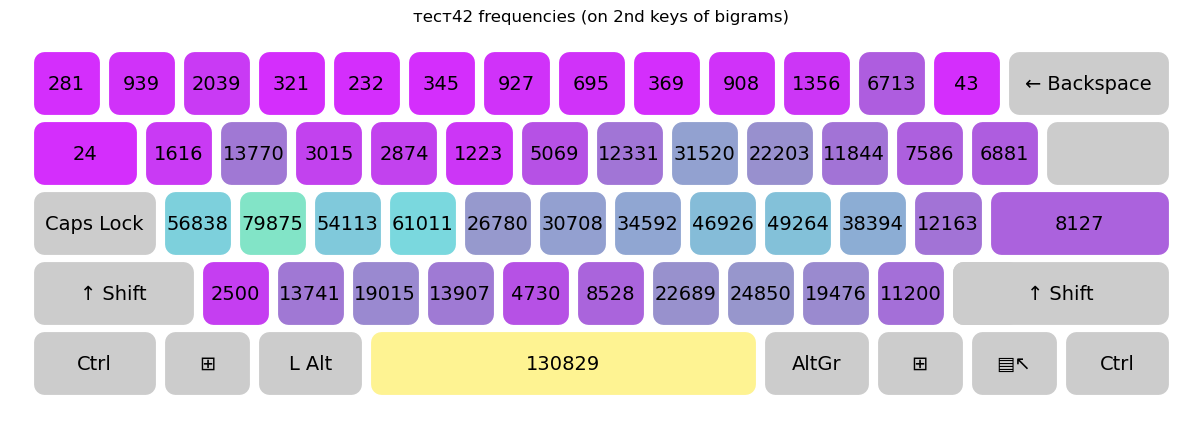

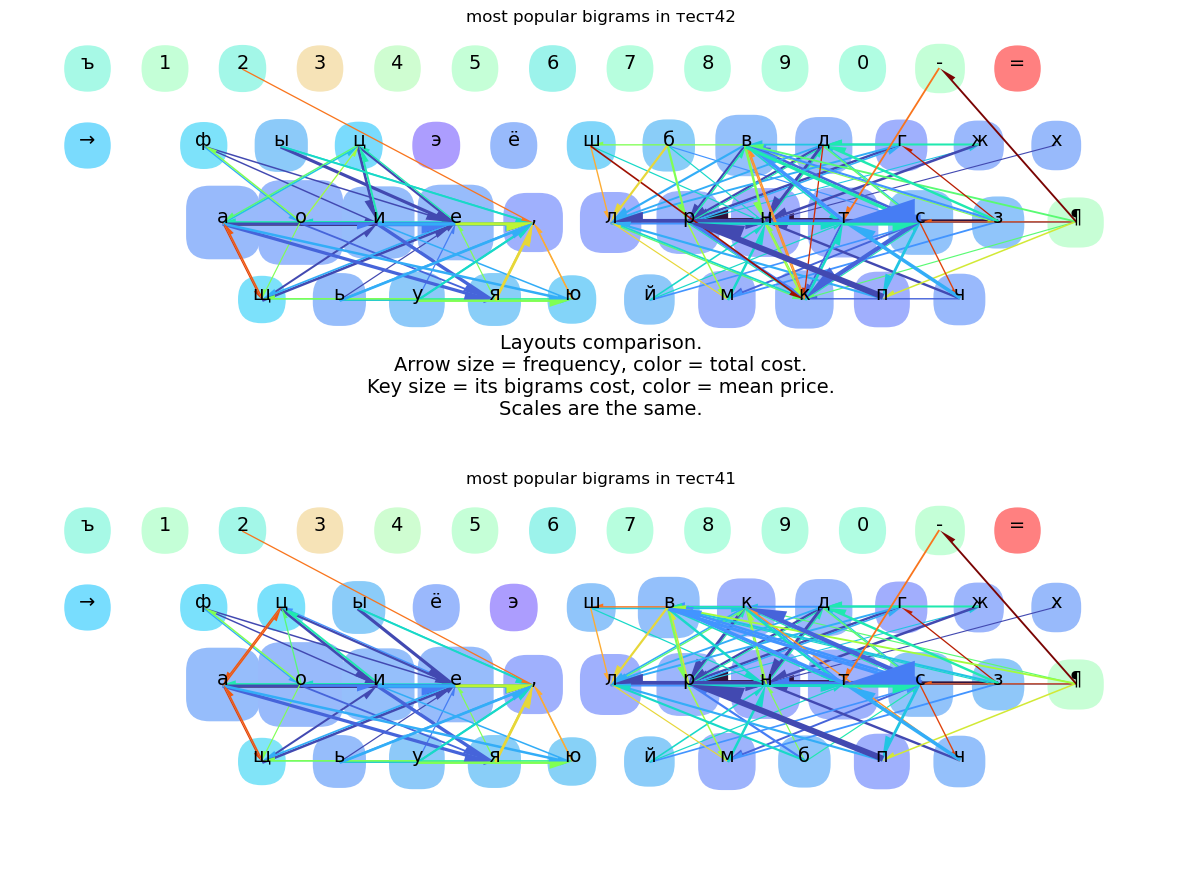

In [19]:
results['тест42'].display('num')
results['тест42'].combomap(results['тест41'])
results['тест41'].compare(results['тест42']).sort_values('delta', ascending=False).head(30)

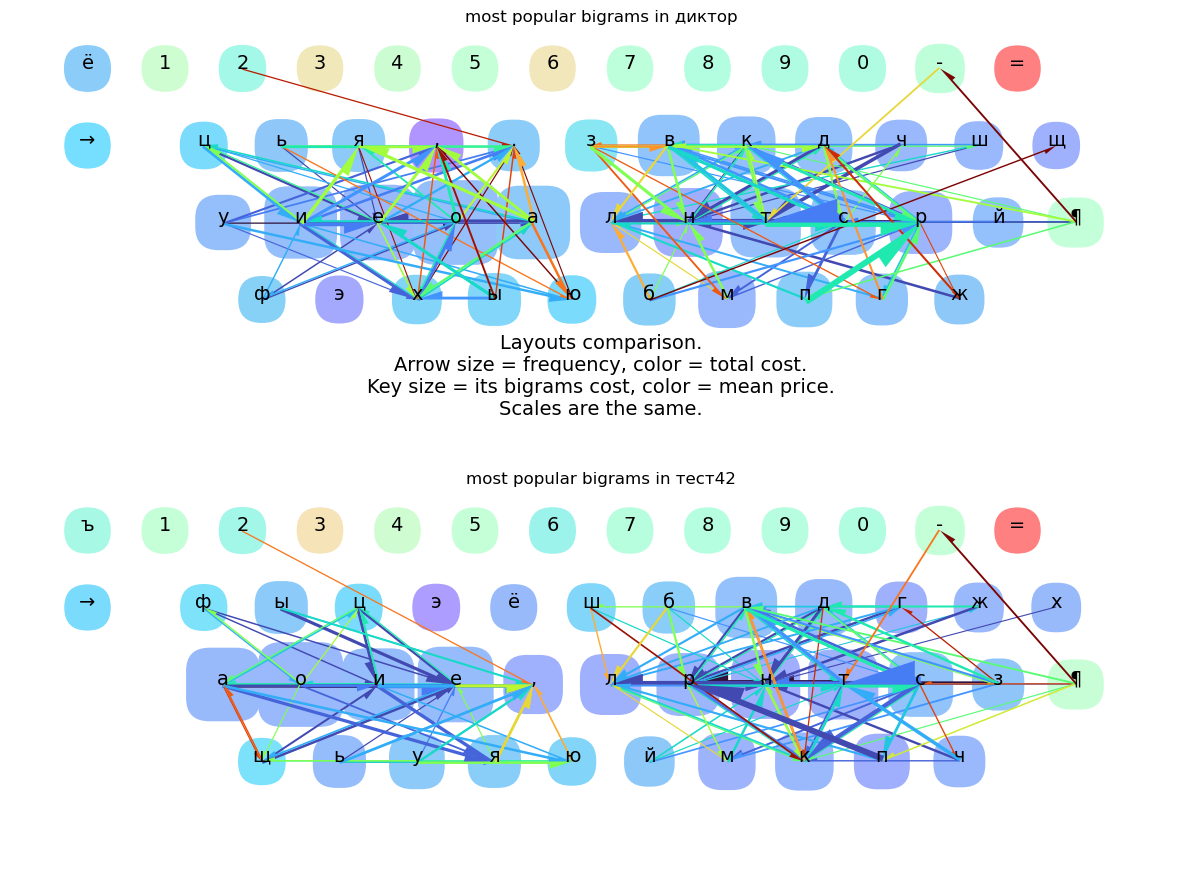

In [20]:
results['диктор'].combomap(results['тест42'])

## Losses

In [21]:
compare(results, 'тест41', 'тест42').head(30)

bigram   num                    coord_cat_old  coord_cost_old  \
225     ⌴б  4888                        space bar               0   
364     шк   467           index->middle same row               1   
463     вс  1832                   index -> pinky               2   
324     бр   812  in, adj finger, same or adj row               2   
187     об  3213                     altern hands               0   
346     бл   789  in, adj finger, same or adj row               2   
451     дк   279  in, adj finger, same or adj row               2   
186     вн  1016             out, over one finger               4   
446     вк   278           index->middle same row               1   
458     кв   365  in, adj finger, same or adj row               2   
31      кр  1386                    in, lower row               1   
11      аб  1157                     altern hands               0   
144     еб   842                     altern hands               0   
562     жк   101      in, over 1 finger, same row               0   
772     гк    98      in, over 1 finger, same row               0   
435     уб   576                     altern hands               0   
389     (к    62                    in, lower row               1   
410     дв   536      in, over 1 finger, same row               0   
376     ец   265                   index -> pinky               2   
275     иб   505                     altern hands               0   
363     кл   467                    in, lower row               1   
600     -к    66       in, over 1 finger, adj row               1   
616     яц    74                   index -> pinky               2   
554     вз   220                   index -> pinky               2   
354     рб   116             out, over one finger               4   
474     цы   150  in, adj finger, same or adj row               2   
465     мб    36           index->middle same row               1   
230     юц    48                   index -> pinky               2   
733     бк   139             same finger over row               8   
357     оц   277          ring -> pinky, next row               5   

     move_cost_old          move_cat_old  cost_old  \
225            0.5  alternating or space    4888.0   
364            2.0                    ok    1634.5   
463            0.0                    ok    4580.0   
324            0.0                    ok    1624.0   
187            0.5  alternating or space    3213.0   
346            1.0                    ok    3156.0   
451            1.0                    ok     976.5   
186            0.0                    ok    4064.0   
446            1.0                    ok     695.0   
458            1.0                    ok    1642.5   
31             0.0                    ok    1386.0   
11             0.5  alternating or space    1157.0   
144            0.5  alternating or space     842.0   
562            2.0                    ok     252.5   
772            1.0                    ok     147.0   
435            0.5  alternating or space     576.0   
389            4.0                    ok     341.0   
410            1.0                    ok    1340.0   
376            0.0                    ok     662.5   
275            0.5  alternating or space     505.0   
363            1.0                    ok    1401.0   
600            5.0                    ok     429.0   
616            2.0                    ok     333.0   
554            1.0                    ok     880.0   
354            0.0                    ok     522.0   
474            4.0                    ok     975.0   
465            1.0                    ok      90.0   
230            4.0                    ok     312.0   
733            1.0                    ok    1320.5   
357            0.0                    ok    1523.5   

                       coord_cat_new  coord_cost_new  move_cost_new  \
225                        space bar               0            0.5   
364              adj finger over row           

## Gains

In [22]:
compare(results, 'тест41', 'тест42').tail(30)

bigram    num                    coord_cat_old  coord_cost_old  \
1377     -б     35        over 1 finger, over 1 row               8   
204      жб     30        over 1 finger, over 1 row               8   
413      яв    281                     altern hands               0   
891      бв     32              adj finger over row              10   
697      бх     54        over 1 finger, over 1 row               8   
87       ув    354                     altern hands               0   
359      бс    231             out, over one finger               4   
494      бн    235              same finger adj row               6   
307      тк    493  in, adj finger, same or adj row               2   
593      щё    151        over 1 finger, over 1 row               8   
1133     пк     70              adj finger over row              10   
273      ¶в    589       in, over 1 finger, adj row               1   
495      мк     71              adj finger over row              10   
462      зв    753       in, over 1 finger, adj row               1   
118      ыв    858                     altern hands               0   
569      рв    364              same finger adj row               6   
200      ев   1126                     altern hands               0   
348      св   1146       in, over 1 finger, adj row               1   
519      вш    295              same finger adj row               6   
182      ⌴э   2440                        space bar               0   
666      йк    183              adj finger over row              10   
298      ца    345                    pinky adj row              10   
108      ив   2032                     altern hands               0   
42       ав   2408                     altern hands               0   
606      чк    339        over 1 finger, over 1 row               8   
289      ац    399                    pinky adj row              10   
294      вр    751              same finger adj row               6   
338      вл    794              same finger adj row               6   
35       ов   6667                     altern hands               0   
18       ⌴в  11347                        space bar               0   

      move_cost_old          move_cat_old  cost_old  \
1377            5.0                    ok     472.5   
204             2.0                    ok     315.0   
413             0.5  alternating or space     562.0   
891             1.0                    ok     400.0   
697             5.0                    ok     810.0   
87              0.5  alternating or space     708.0   
359             0.0                    ok    1039.5   
494             0.0                    ok    1410.0   
307             0.0                    ok    1232.5   
593             2.0                    ok    1585.5   
1133            1.0                    ok     805.0   
273             4.0                    ok    3828.5   
495             1.0                    ok     816.5   
462             1.0                    ok    2635.5   
118             0.5  alternating or space    1716.0   
569             0.0                    ok    2730.0   
200             0.5  alternating or space    2252.0   
348             0.0                    ok    2865.0   
519             2.0                    ok    2950.0   
182             1.0  alternating or space    4880.0   
666             2.0                    ok    2287.5   
298             0.0                    ok    3622.5   
108             0.5  alternating or space    4064.0   
42              0.5  alternating or space    4816.0   
606             1.0                    ok    3220.5   
289             0.0                    ok    4189.5   
294             0.0                    ok    4506.0   
338             1.0                    ok    6352.0   
35              0.5  alternating or space   13334.0   
18              0.5  alternating or space   22694.0   

                        coord_cat_new  coord_cost_new  move_cost_new  \
1377       in, over 1 fin

You can save the comparison table to CSV:

In [23]:
compare(results, 'леонов', 'тест42').to_csv('leonov-test42.csv')

## Simple Statistics, What Cost The Most <a name="simple-stats">

In [24]:
results['тест42'].bigrams.sort_values('cost', ascending=False).head(30) #.to_csv('/tmp/test26.csv')

bigram    num l1 l2 t1 t2      freq  row1  column1  row2  ...  \
125     --   2097  -  -  -  -  0.002304     0       12     0  ...   
53      ¶¶   2870  ¶  ¶  -  -  0.003154     2       13     2  ...   
48      ст  10549  с  т  c  c  0.011592     2       11     2  ...   
802     ¶-    586  ¶  -  -  -  0.000644     2       13     0  ...   
177     .¶   3921  .  ¶  -  -  0.004309     2        5     2  ...   
40      ⌴п  13192  ⌴  п  -  c  0.014497     4        0     3  ...   
18      ⌴в  11347  ⌴  в  -  c  0.012469     4        0     1  ...   
124     ⌴-   2268  ⌴  -  -  -  0.002492     4        0     0  ...   
272     е,   1459  е  ,  v  -  0.001603     2        4     2  ...   
225     ⌴б   4888  ⌴  б  -  c  0.005371     4        0     1  ...   
181     ой   3205  о  й  v  c  0.003522     2        2     3  ...   
132     я,   1162  я  ,  v  -  0.001277     3        4     2  ...   
465     вс   1832  в  с  c  c  0.002013     1        9     2  ...   
93      ал   5153  а  л  v  c  0.005663     2        1     2  ...   
45      ел   4887  е  л  v  c  0.005370     2        4     2  ...   
130     тс   1614  т  с  c  c  0.001774     2       10     2  ...   
88      ол   4749  о  л  v  c  0.005219     2        2     2  ...   
111     их   1574  и  х  v  c  0.001730     2        3     1  ...   
30      ⌴к   6687  ⌴  к  -  c  0.007348     4        0     3  ...   
35      ов   6667  о  в  v  c  0.007326     2        2     1  ...   
350     я.    806  я  .  v  -  0.000886     3        4     2  ...   
187     об   3213  о  б  v  c  0.003531     2        2     1  ...   
134     чт   2120  ч  т  c  c  0.002330     3       11     2  ...   
365     е.    905  е  .  v  -  0.000995     2        4     2  ...   
346     бл    789  б  л  c  c  0.000867     1        8     2  ...   
378     ую   1019  у  ю  v  v  0.001120     3        3     3  ...   
186     вн   1016  в  н  c  c  0.001116     1        9     2  ...   
71      ых   1340  ы  х  v  c  0.001473     1        2     1  ...   
296     ей   2010  е  й  v  c  0.002209     2        4     3  ...   
41      пр   6010  п  р  c  c  0.006604     3       10     2  ...   

                 move_cat  voff hoff  row column  finger  ftype  hand  \
125                    ok   0.0  0.0    0     12       9      4     1   
53                     ok   0.0  0.0    2     13       9      4     1   
48                     ok   0.0  0.0    2     10       8      3     1   
802                    ok   2.0  1.0    0     12       9      4     1   
177  alternating or space   0.0 -1.0    2     13       9      4     1   
40   alternating or space  -0.5  0.0    3     10       8      3     1   
18   alternating or space   0.5  0.0    1      9       7      2     1   
124  alternating or space   1.0 -0.5    0     12       9      4     1   
272                    ok   0.0  1.0    2      5       3      1     0   
225  alternating or space   0.5  0.0    1      8       6      1     1   
181  alternating or space  -0.5  0.5    3      7       6      1     1   
132                    ok   1.0  1.0    2      5       3      1     0   
465                    ok   1.0  0.0    2     11       9      4     1   
93   alternating or space   0.0  0.5    2      7       6      1     1   
45   alternating or space   0.0  0.5    2      7       6      1     1   
130                    ok   0.0  0.0    2     11       9      4     1   
88   alternating or space   0.0  0.5    2      7       6      1     1   
111  alternating or space   0.5 -1.0    1     13       9      4     1   
30   alternating or space  -0.5  0.0    3      9       7      2     1   
35   alternating or space   0.5  0.0    1      9       7      2     1   
350                    ok   1.0  1.0    2      5       3      1     0   
187  alternating or space   0.5  0.0    1      8       6      1     1   
134                    ok   1.0  0.0    2     10       8      3     1   
365                    ok   0.0  1.0    2      5       3      1     0   
346                    ok   1.0  1.0   

## Statistics of Bigrams to CSV <a name="output-statistics">

We count how often a key comes before or after which one. We add categories to simplify statistics analysis: vowel/consonant/other, hand (in layout 27), row, column. 

In [25]:
key = 'тест38'
res = results[key]

keys_df = (res.layout.keymap[['row', 'column']]
 .reset_index()
 .merge(res.layout.keyboard.keymap, on=['row', 'column'])
).set_index('index')


b1 = CORP.bigrams.merge(keys_df, left_on='l1', right_index=True
    ).merge(keys_df, left_on='l2', right_index=True, suffixes=('_self', '_other')
    ).merge(r.layout.keyboard.bigrams, left_on=['row_self', 'column_self', 'row_other', 'column_other'], right_index=True
    )
b1['kind'] = 'forward'
b1.rename(columns={'l1': 'self', 'l2': 'other', 'hand2': 'hand_other', 'hand1': 'hand_self',
                   't1': 'type_self', 't2': 'type_other'}, inplace=True)

b2 = CORP.bigrams.merge(keys_df, left_on='l1', right_index=True
    ).merge(keys_df, left_on='l2', right_index=True, suffixes=('_other', '_self')
    ).merge(r.layout.keyboard.bigrams, left_on=['row_other', 'column_other', 'row_self', 'column_self'], right_index=True
    )
b2['kind'] = 'backward'
b2.rename(columns={'l2': 'self', 'l1': 'other', 'hand1': 'hand_other', 'hand2': 'hand_self',
                  't2': 'type_self', 't1': 'type_other'}, inplace=True)

pd.concat([b1, b2]).to_csv(f'all-letters-{key}.csv')

## Check the keymap (for errors) <a name="keymap">

In [26]:
lyt.keymap
# or 
# results['тест28'][1]

layer  row  column  key_count
ъ      0    0       0          1
1      0    0       1          1
2      0    0       2          1
3      0    0       3          1
4      0    0       4          1
5      0    0       5          1
6      0    0       7          1
7      0    0       8          1
8      0    0       9          1
9      0    0      10          1
0      0    0      11          1
-      0    0      12          1
=      0    0      13          1
→      0    1       0          1
ф      0    1       1          1
ц      0    1       2          1
ы      0    1       3          1
ё      0    1       4          1
э      0    1       5          1
ш      0    1       7          1
в      0    1       8          1
б      0    1       9          1
к      0    1      10          1
г      0    1      11          1
ж      0    1      12          1
х      0    1      13          1
а      0    2       1          1
и      0    2       2          1
о      0    2       3          1
е      0    2       4          1
,      0    2       5          1
л      0    2       7          1
р      0    2       8          1
т      0    2       9          1
н      0    2      10          1
с      0    2      11          1
з      0    2      12          1
¶      0    2      13          1
щ      0    3       1          1
ь      0    3       2          1
у      0    3       3          1
я      0    3       4          1
ю      0    3       5          1
й      0    3       7          1
м      0    3       8          1
д      0    3       9          1
п      0    3      10          1
ч      0    3      11          1
⌴      0    4       0          1
\      1    0       0          1
!      1    0       1          1
"      1    0       2          1
№      1    0       3          1
;      1    0       4          1
%      1    0       5          1
:      1    0       7          1
?      1    0       8          1
*      1    0       9          1
(      1    0      10          1
)      1    0      11          1
_      1    0      12          1
+      1    0      13          1
.      1    2       5          1

# Arrow Maps

All Russian layouts vs ЙЦУКЕН. Skoropis is essentially Diktor with modified punctuation marks, and is omitted.

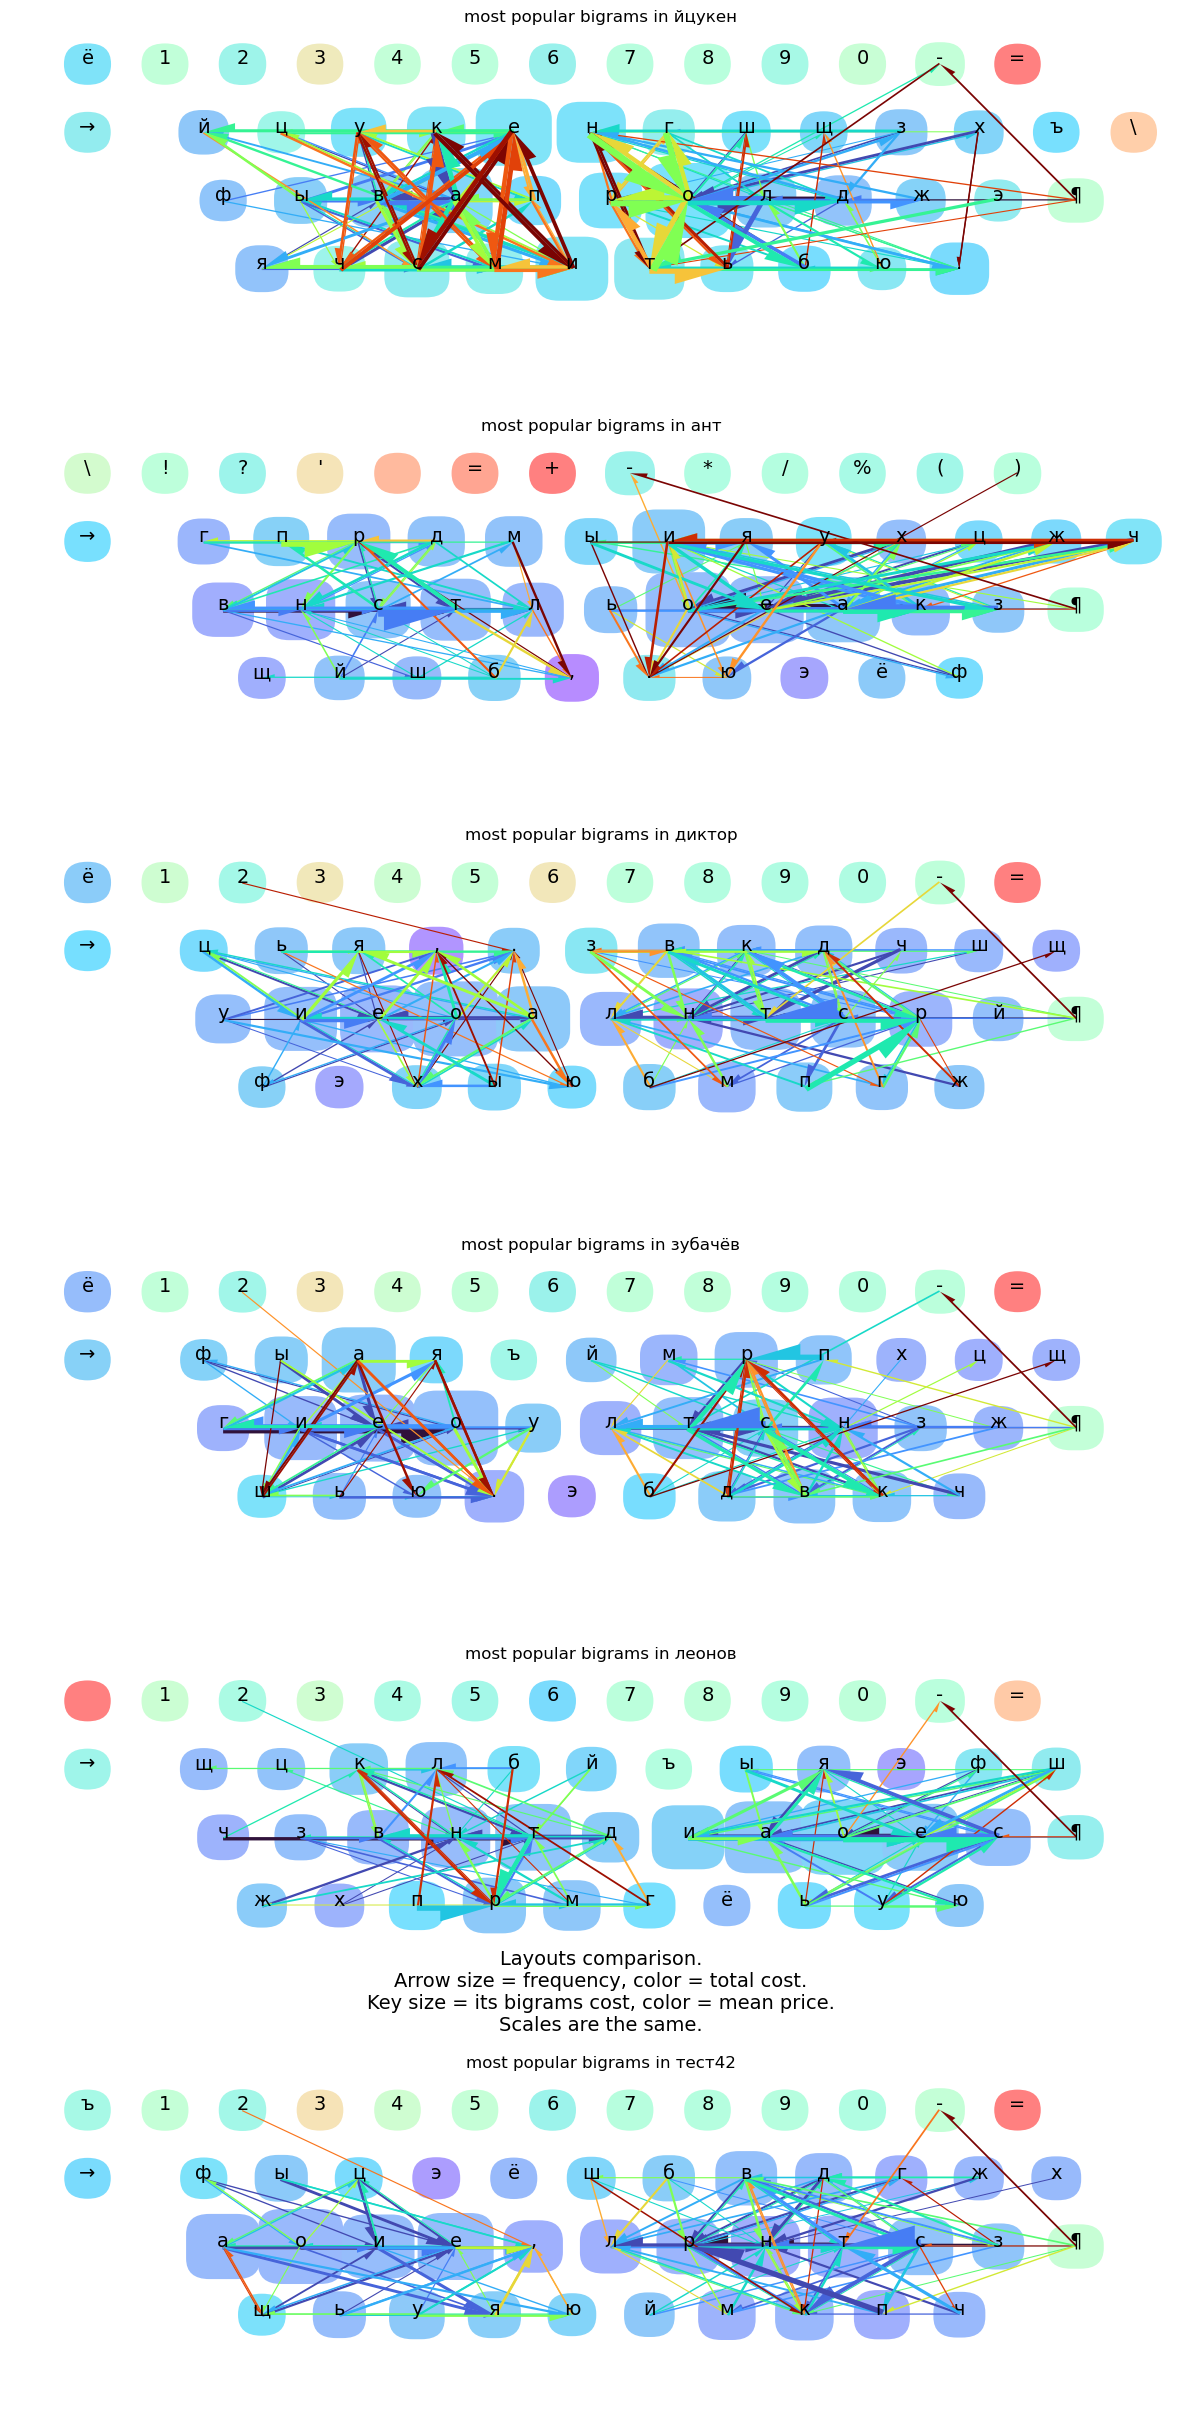

In [27]:
rs = results
rs['йцукен'].combomap(rs['ант'], rs['диктор'], rs['зубачёв'], rs['леонов'], rs['тест42'])

# Heatmaps <a name="heatmaps">

To see the heatmap by just number of key presses, use `pivot_table('num'`, to see the one for penalties, use `pivot_table('cost'`.

In [28]:
results['йцукен'].layout.keymap

layer  row  column  key_count
ё      0    0       0          1
1      0    0       1          1
2      0    0       2          1
3      0    0       3          1
4      0    0       4          1
5      0    0       5          1
6      0    0       7          1
7      0    0       8          1
8      0    0       9          1
9      0    0      10          1
0      0    0      11          1
-      0    0      12          1
=      0    0      13          1
→      0    1       0          1
й      0    1       1          1
ц      0    1       2          1
у      0    1       3          1
к      0    1       4          1
е      0    1       5          1
н      0    1       7          1
г      0    1       8          1
ш      0    1       9          1
щ      0    1      10          1
з      0    1      11          1
х      0    1      12          1
ъ      0    1      13          1
\      0    1      14          1
ф      0    2       1          1
ы      0    2       2          1
в      0    2       3          1
а      0    2       4          1
п      0    2       5          1
р      0    2       7          1
о      0    2       8          1
л      0    2       9          1
д      0    2      10          1
ж      0    2      11          1
э      0    2      12          1
¶      0    2      13          1
я      0    3       1          1
ч      0    3       2          1
с      0    3       3          1
м      0    3       4          1
и      0    3       5          1
т      0    3       7          1
ь      0    3       8          1
б      0    3       9          1
ю      0    3      10          1
.      0    3      11          1
⌴      0    4       0          1
~      1    0       0          1
!      1    0       1          1
"      1    0       2          1
№      1    0       3          1
;      1    0       4          1
%      1    0       5          1
:      1    0       7          1
?      1    0       8          1
*      1    0       9          1
(      1    0      10          1
)      1    0      11          1
_      1    0      12          1
+      1    0      13          1
,      1    3      11          1

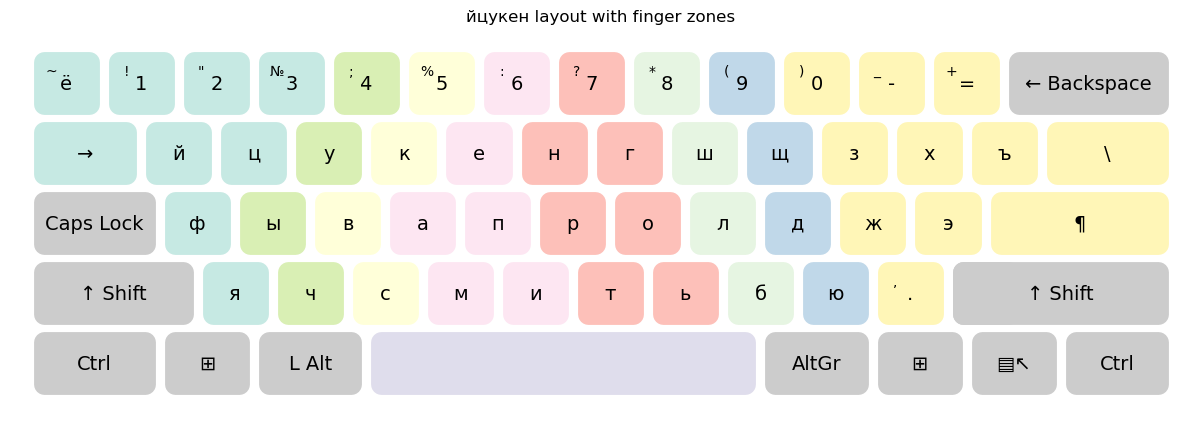

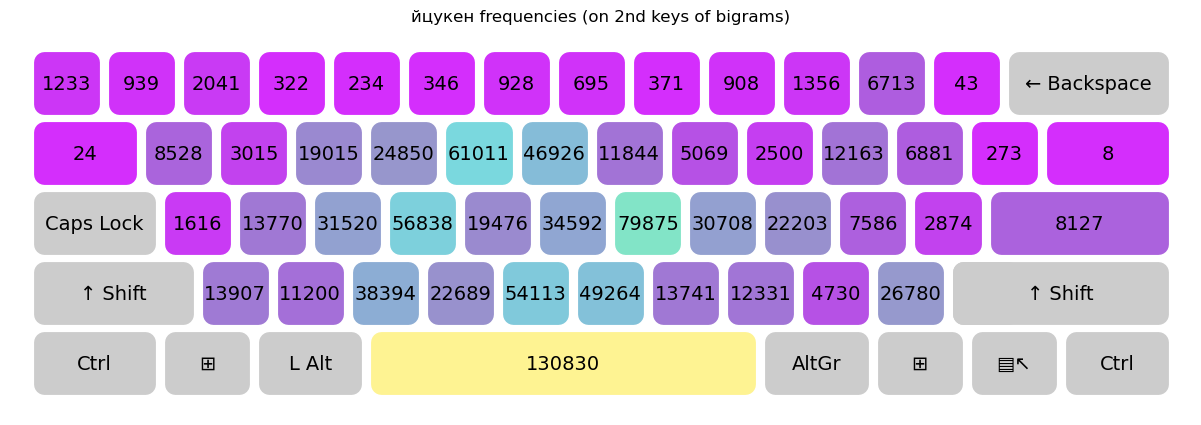

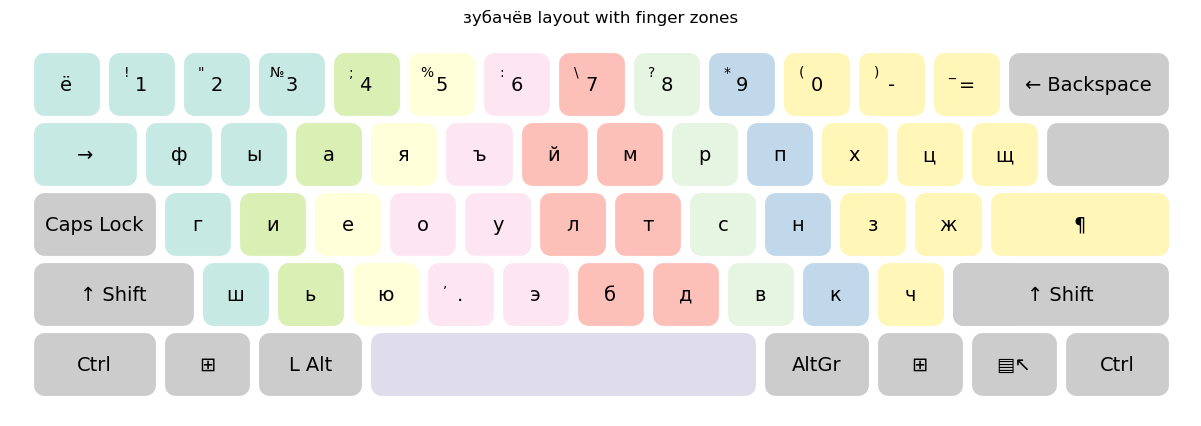

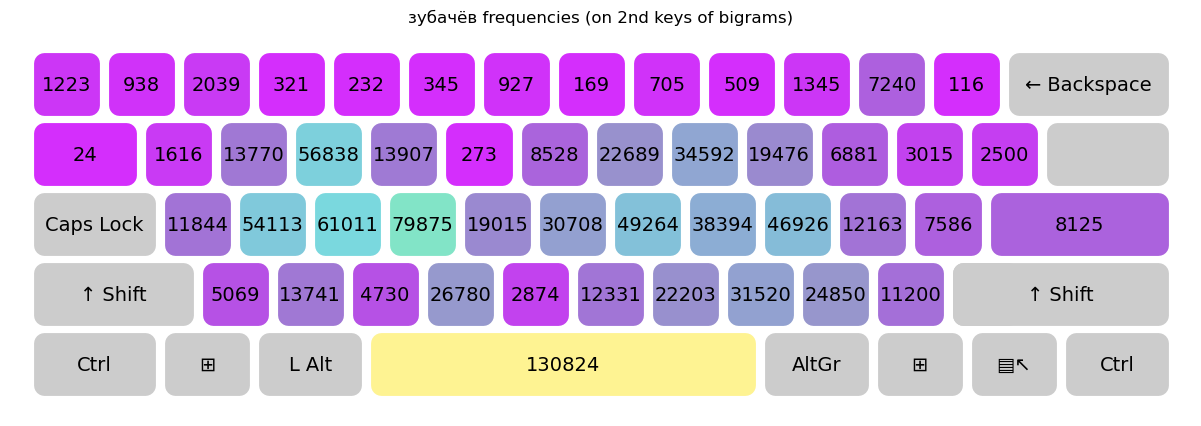

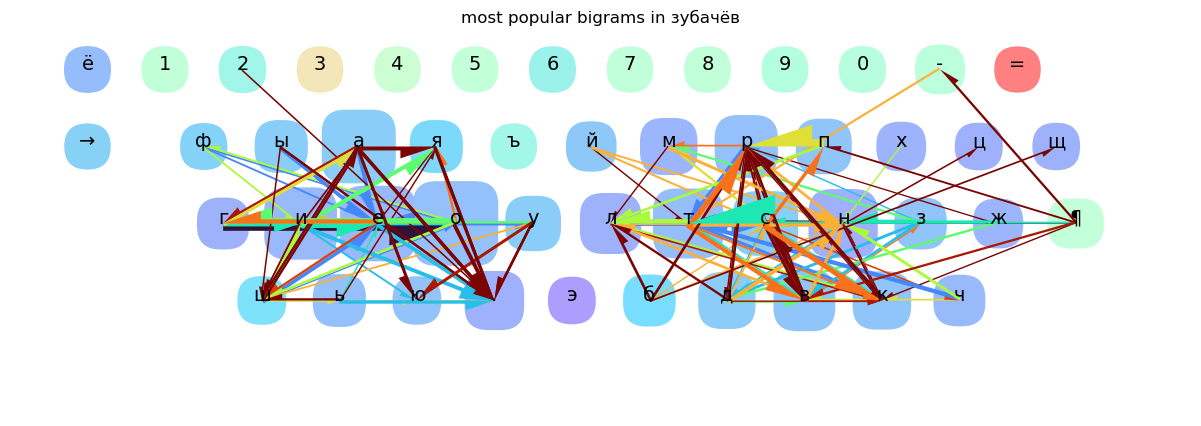

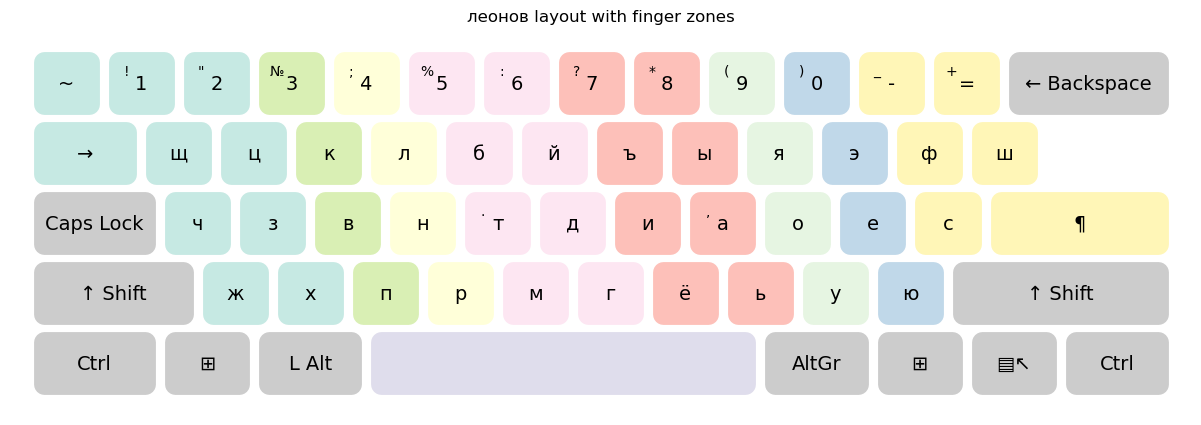

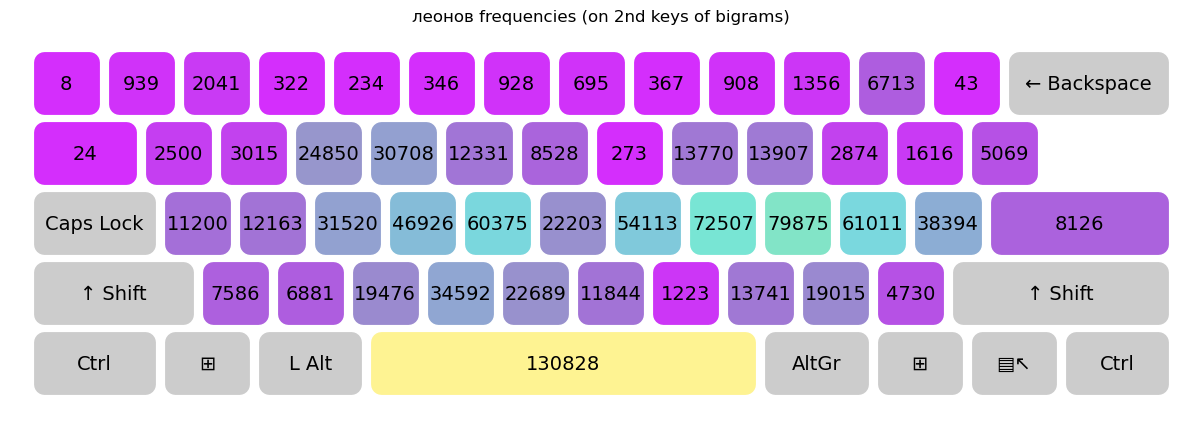

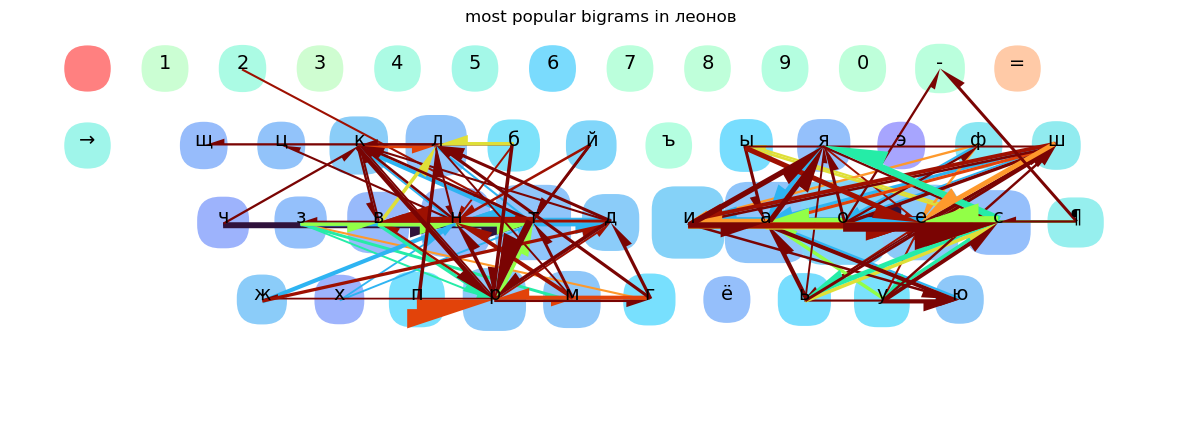

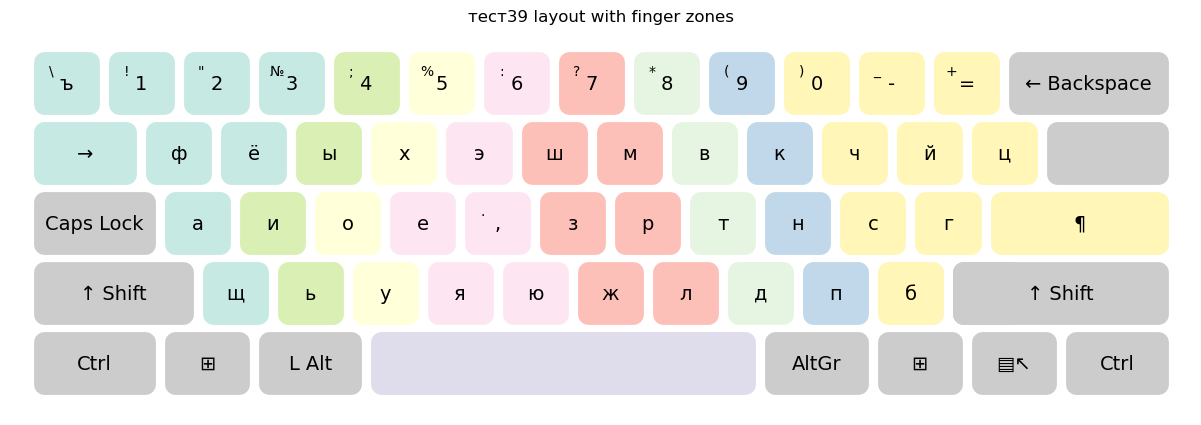

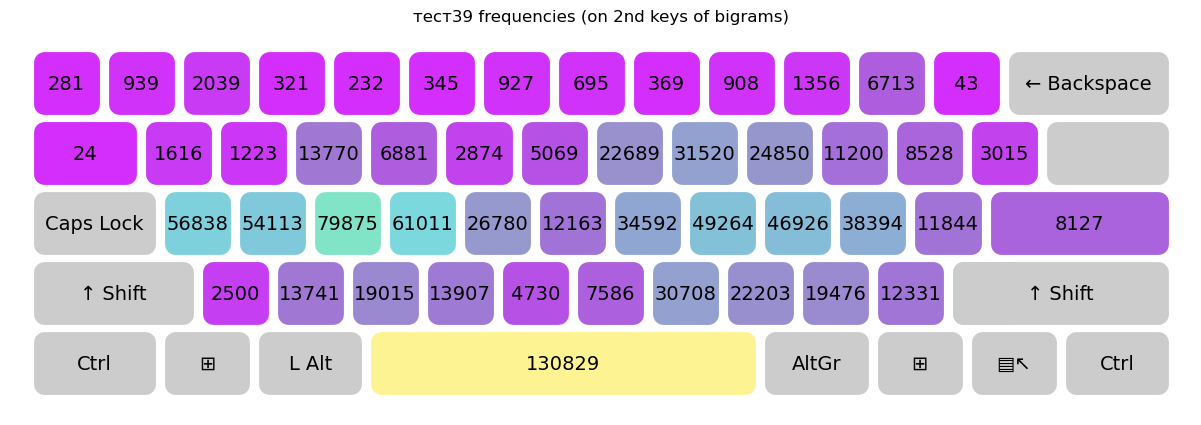

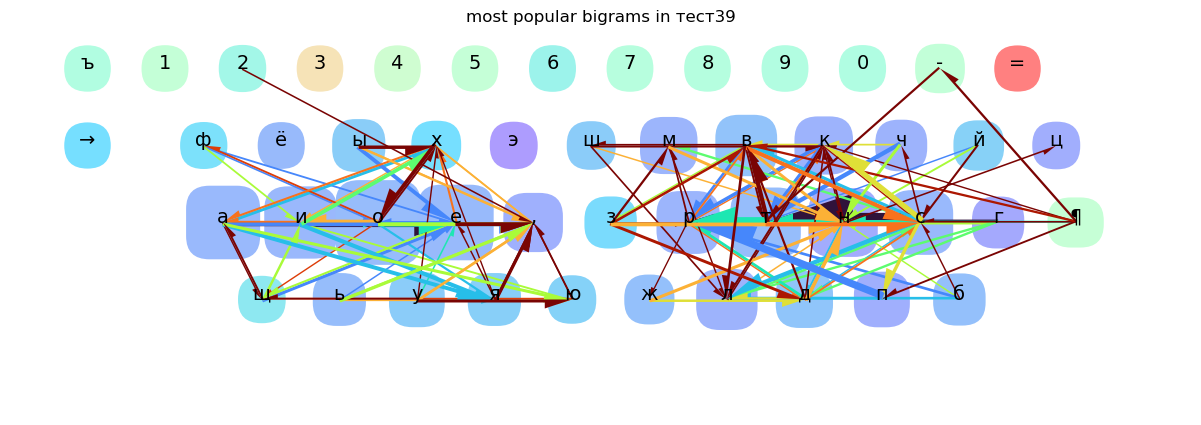

In [29]:
results['йцукен'].display('layout', 'num')
results['зубачёв'].display('layout', 'num', 'arrows')
results['леонов'].display('layout', 'num', 'arrows')
results['тест39'].display('layout', 'num', 'arrows')

# Comparison of best others' and mine

In [30]:
cmp = compare(results, 'леонов', 'тест39')
cmp.head(30)

bigram    num                    coord_cat_old  coord_cost_old  \
53      ¶¶   2870                         same key               0   
125     --   2097                         same key               0   
18      ⌴в  11347                        space bar               0   
272     е,   1459      in, over 1 finger, same row               0   
757     ¶-    586                   pinky over row              12   
194     хо   1638                     altern hands               0   
177     .¶   3921                     altern hands               0   
132     я,   1162                    in, lower row               1   
114     ск   3125                     altern hands               0   
71      ых   1340                     altern hands               0   
463     вс   1832                     altern hands               0   
338     вл    794  in, adj finger, same or adj row               2   
35      ов   6667                     altern hands               0   
196     зн   1644      in, over 1 finger, same row               0   
130     тс   1614                     altern hands               0   
350     я.    806                     altern hands               0   
365     е.    905                     altern hands               0   
25      ⌴м   5232                        space bar               0   
49      тв   2081             out, over one finger               4   
222     йс    467                     altern hands               0   
445     зд    979      in, over 1 finger, same row               0   
409     дн   1467           index->middle same row               1   
871     ща    415                     altern hands               0   
457     -т    542                     altern hands               0   
191     ом   4114                     altern hands               0   
105     на   8004                     altern hands               0   
496     зм    567       in, over 1 finger, adj row               1   
10      ра   7597                     altern hands               0   
94      ⌴з   3467                        space bar               0   
14      тн   1148           index->middle same row               1   

     move_cost_old          move_cat_old  cost_old  \
53             1.0                    ok    5740.0   
125           16.0                    ok   36697.5   
18             0.0  alternating or space       0.0   
272            0.0                    ok       0.0   
757            4.0                    ok   10255.0   
194            0.0  alternating or space       0.0   
177            0.5  alternating or space    5881.5   
132            0.0                    ok    1162.0   
114            0.5  alternating or space    3125.0   
71             0.5  alternating or space    1340.0   
463            0.0  alternating or space     916.0   
338            0.0                    ok    1985.0   
35             0.0  alternating or space       0.0   
196            0.0                    ok       0.0   
130            0.0  alternating or space     807.0   
350            0.0  alternating or space       0.0   
365            0.0  alternating or space       0.0   
25             0.5  alternating or space    5232.0   
49             0.0                    ok    8324.0   
222            0.0  alternating or space     233.5   
445            0.0                    ok     979.0   
409            0.0                    ok    1467.0   
871            0.0  alternating or space       0.0   
457            0.0  alternating or space       0.0   
191            0.5  alternating or space    4114.0   
105            0.0  alternating or space       0.0   
496            0.0                    ok     850.5   
10             0.0  alternating or space       0.0   
94             0.0  alternating or space    1733.5   
14             0.0                    ok    1148.0   

                       coord_cat_new  coord_cost_new  move_cost_new  \
53                          same key               0           16.0   
125             

In [31]:
cmp.tail(30)

bigram   num                    coord_cat_old  coord_cost_old  \
9       ⌴р  4077                        space bar               0   
301     гд   645              same finger adj row               6   
110     ки  2886                     altern hands               0   
218     ше  1528          pinky -> ring, next row               3   
211     ер  4780                     altern hands               0   
156     ис  2458                   index -> pinky               2   
79      ⌴г  3298                        space bar               0   
153     ог  3341                     altern hands               0   
256     ые  1696             out, over one finger               4   
404     се  2650  in, adj finger, same or adj row               2   
277     ая  1782             out, over one finger               4   
33      ти  3904                     altern hands               0   
69      ор  5921                     altern hands               0   
129     ае  1585             out, over one finger               4   
28      ри  4244                     altern hands               0   
489     гл   645              adj finger over row              10   
238     ас  3302                   index -> pinky               2   
262     ия  1949             out, over one finger               4   
252     пл   786              adj finger over row              10   
300     и,  1600              same finger adj row               6   
78      тр  3288             out, over one finger               4   
7       ли  5507                     altern hands               0   
324     бр   812              adj finger over row              10   
155     ие  2374             out, over one finger               4   
15      ни  7156                     altern hands               0   
23      ⌴и  9284                        space bar               0   
31      кр  1386              adj finger over row              10   
41      пр  6010  in, adj finger, same or adj row               2   
61      ес  4129             out, over one finger               4   
56      ос  5489             out, over one finger               4   

     move_cost_old          move_cat_old  cost_old  \
9              0.5  alternating or space    4077.0   
301            2.0                    ok    5805.0   
110            0.5  alternating or space    4329.0   
218            0.0                    ok    4584.0   
211            0.5  alternating or space    4780.0   
156            0.0                    ok    6145.0   
79             1.0  alternating or space    9894.0   
153            1.0  alternating or space   10023.0   
256            0.0                    ok    6784.0   
404            0.0                    ok    5300.0   
277            0.0                    ok    8019.0   
33             0.5  alternating or space    5856.0   
69             0.5  alternating or space    5921.0   
129            0.0                    ok    6340.0   
28             0.5  alternating or space    6366.0   
489            2.0                    ok    8062.5   
238            0.0                    ok    8255.0   
262            1.0                    ok   10719.5   
252            1.0                    ok    9039.0   
300            0.0                    ok    9600.0   
78             0.0                    ok   14796.0   
7              0.5  alternating or space    8260.5   
324            1.0                    ok    9338.0   
155            0.0                    ok    9496.0   
15             0.5  alternating or space   10734.0   
23             0.5  alternating or space   13926.0   
31             1.0                    ok   15939.0   
41             1.0                    ok   21035.0   
61             0.0                    ok   18580.5   
56             0.0                    ok   24700.5   

                       coord_cat_new  coord_cost_new  move_cost_new  \
9                          space bar               0            0.0   
301       in, over 1 finger, adj row           